In [118]:
%matplotlib inline

## Dataset download ##

### Import ###

In [119]:
%matplotlib inline


import hashlib
import os
import tarfile
import zipfile
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### Download source config ###

In [120]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

### Download ###

In [121]:
def download(name, cache_dir=os.path.join(".", "data")):
    assert name in DATA_HUB, f"{name} is not existed in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f"Downloading {fname} from {url}")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname

### Add download source ###

In [122]:
DATA_HUB["kaggle_house_train"] = (  # @save
    DATA_URL + "kaggle_house_pred_train.csv",
    "585e9cc93e70b39160e7921475f9bcd7d31219ce",
)

DATA_HUB["kaggle_house_test"] = (  # @save
    DATA_URL + "kaggle_house_pred_test.csv",
    "fa19780a7b011d9b009e8bff8e99922a8ee2eb90",
)

## Data Preprocessing ##

### Load dataset ###

In [123]:
train_data = pd.read_csv(download("kaggle_house_train"))
test_data = pd.read_csv(download("kaggle_house_test"))

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### Centering and fill NaN ###

In [124]:
numeric_features = all_features.dtypes[all_features.dtypes != "object"].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: ((x - x.mean()) / x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

### One hot ###

In [125]:
all_features = pd.get_dummies(all_features, dummy_na=True)

### To Tensor ###

In [126]:
n_train = train_data.shape[0]
train_features = torch.tensor(
    all_features[:n_train].astype("float32").values, dtype=torch.float32
)
test_features = torch.tensor(
    all_features[n_train:].astype("float32").values, dtype=torch.float32
)
train_labels = torch.tensor(
    train_data["SalePrice"].astype("float32").values, dtype=torch.float32
).reshape(-1, 1)

## Model ##

### Hyper params ###

In [127]:
num_inputs = train_features.shape[-1]
lr = 0.5
wd = 0.5
k = 10
num_epochs = 200
batch_size = 64

### Net Define ###

In [128]:
net = nn.Sequential(nn.Linear(num_inputs, 1))

### Function Define ###

In [129]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

### Iter ###

In [130]:
def init_iter(data_arrays, batch_size, shuffle):
    temp = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(temp, batch_size, shuffle)

### Log RMSE ###

In [131]:
def log_rmse(net, features, labels, loss=loss):
    temp = torch.clamp(net(features), 1, float("inf"))
    loss = torch.sqrt(loss(torch.log(temp), torch.log(labels)))
    return float(loss.item())

### Train ###

In [132]:
def train_once(net, train_features, train_labels, test_features, test_labels, optimizer, loss):
    train_iter = init_iter(
        (train_features, train_labels), batch_size=batch_size, shuffle=True
    )
    for X, y in train_iter:
        optimizer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        optimizer.step()
    return log_rmse(net, test_features, test_labels, loss)


def get_k_fold_data(k, i, features, labels):
    assert k > 1
    lenth = len(features)
    assert lenth == len(labels)
    fold_size = lenth // k
    train_features = torch.cat(
        (features[: i * fold_size, :], features[(i + 1) * fold_size :, :]),
        dim=0,
    )
    train_labels = torch.cat(
        (labels[: i * fold_size, :], labels[(i + 1) * fold_size :, :]), dim=0
    )
    test_features = features[i * fold_size : (i + 1) * fold_size, :]
    test_labels = labels[i * fold_size : (i + 1) * fold_size, :]
    return train_features, train_labels, test_features, test_labels


def train(net, features, labels, optimizer, loss, k, num_epochs):
    loss_epoch = []
    print(f"Training in {k} folds:")
    for epoch in range(num_epochs):
        loss_k = []
        for i in range(k):
            train_features, train_labels, test_features, test_labels = get_k_fold_data(
                k, i, features, labels
            )
            loss_k.append(
                train_once(
                    net,
                    train_features,
                    train_labels,
                    test_features,
                    test_labels,
                    optimizer,
                    loss,
                )
            )
        loss_epoch.append(sum(loss_k) / len(loss_k))
        plt.clf()
        plt.plot(range(1, epoch + 2), loss_epoch, color="blue")
        plt.xlabel("epoch")
        plt.ylabel("log rmse")
        plt.show()
        print(f"Loss in epoch {epoch+1} is {loss_epoch[-1]}")
    return loss_epoch

## Main ##

Training in 10 folds:


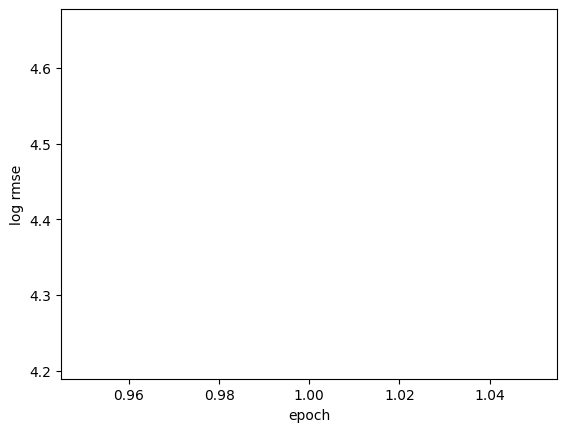

Loss in epoch 1 is 4.433524084091187


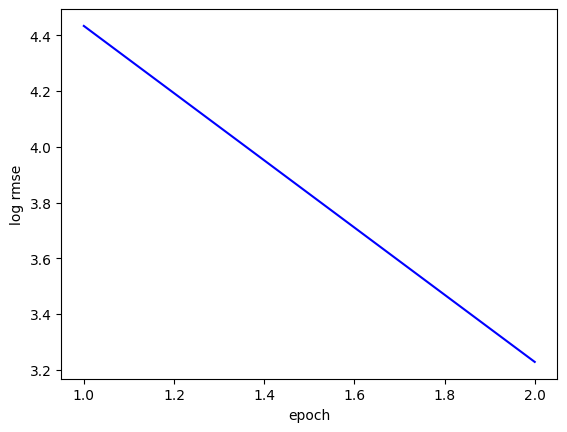

Loss in epoch 2 is 3.228570580482483


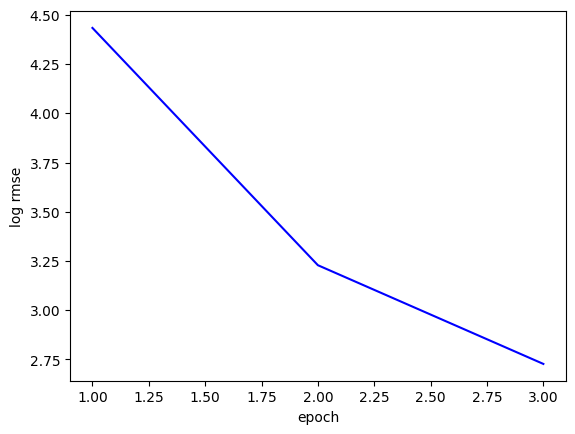

Loss in epoch 3 is 2.7273290872573854


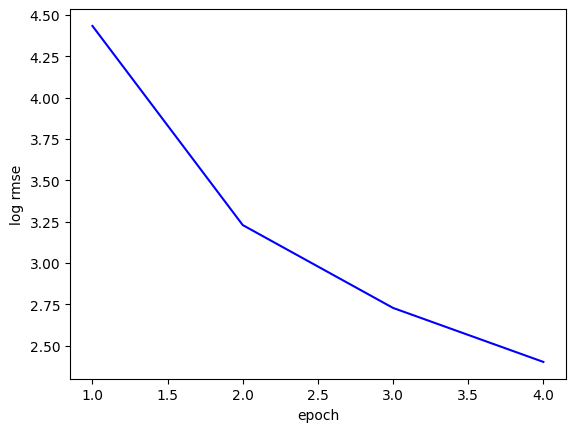

Loss in epoch 4 is 2.4006862878799438


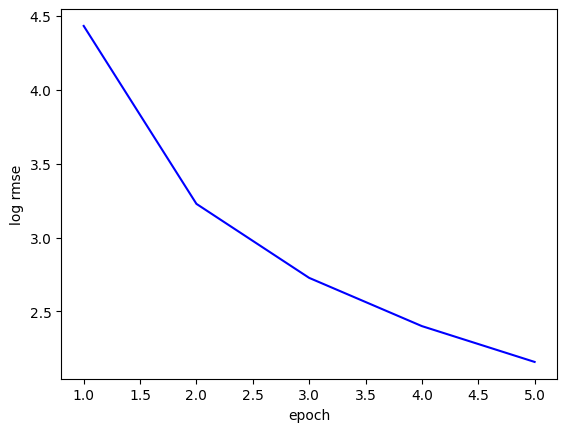

Loss in epoch 5 is 2.1581315755844117


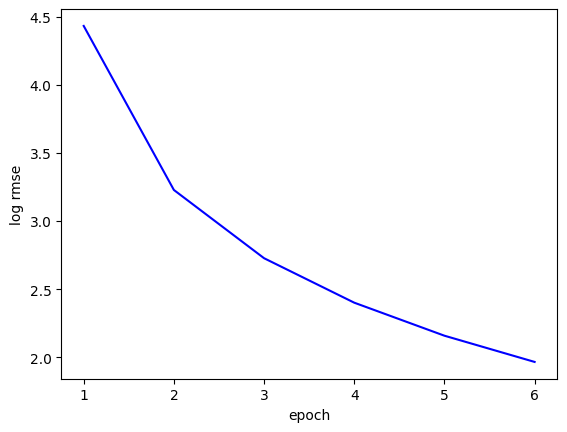

Loss in epoch 6 is 1.9655367493629456


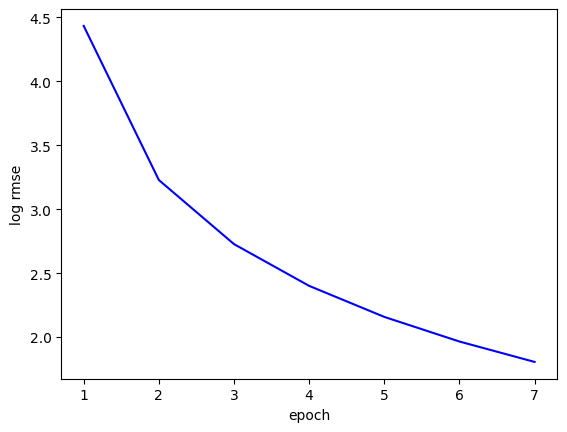

Loss in epoch 7 is 1.806032383441925


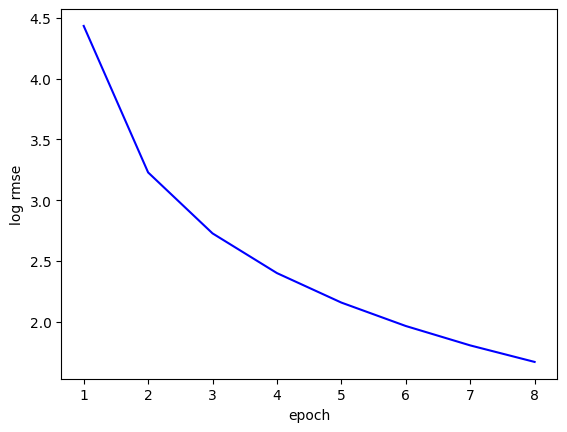

Loss in epoch 8 is 1.670121431350708


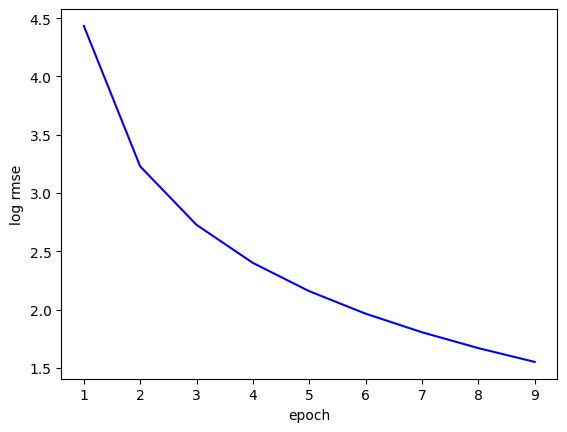

Loss in epoch 9 is 1.5518232226371764


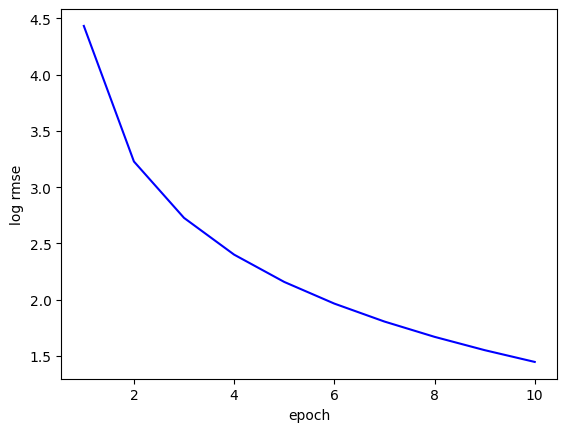

Loss in epoch 10 is 1.4471637606620789


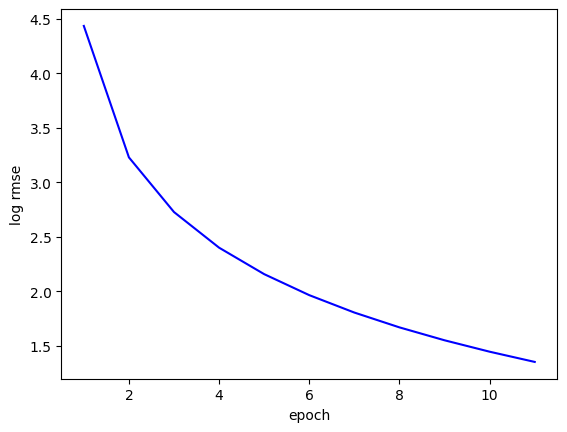

Loss in epoch 11 is 1.3535041451454162


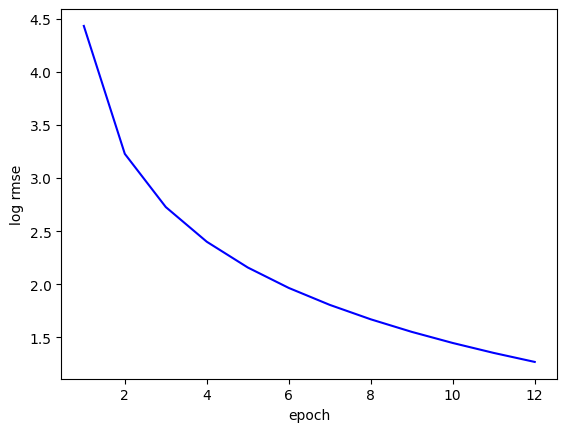

Loss in epoch 12 is 1.2688028335571289


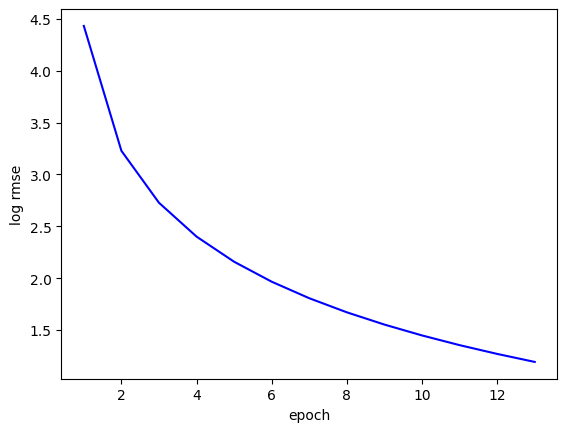

Loss in epoch 13 is 1.1915366411209107


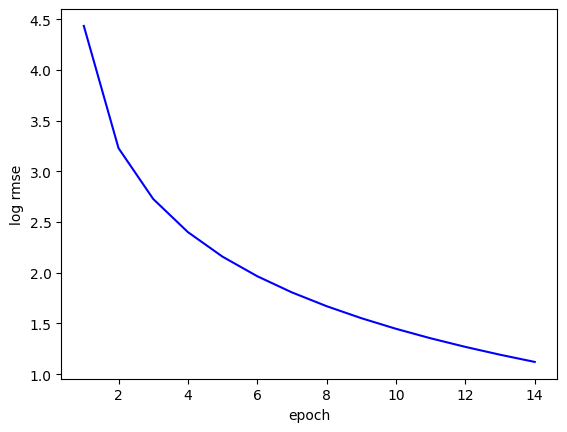

Loss in epoch 14 is 1.1205458641052246


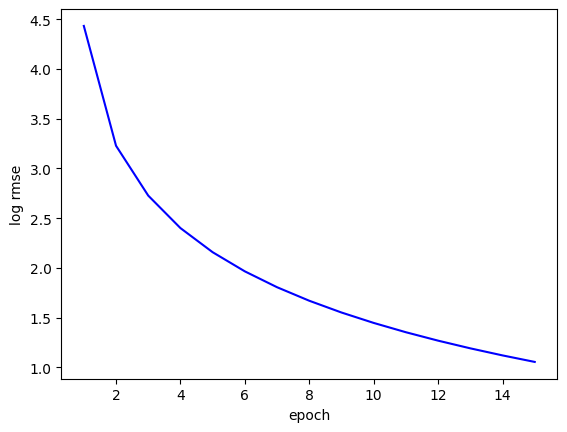

Loss in epoch 15 is 1.05500830411911


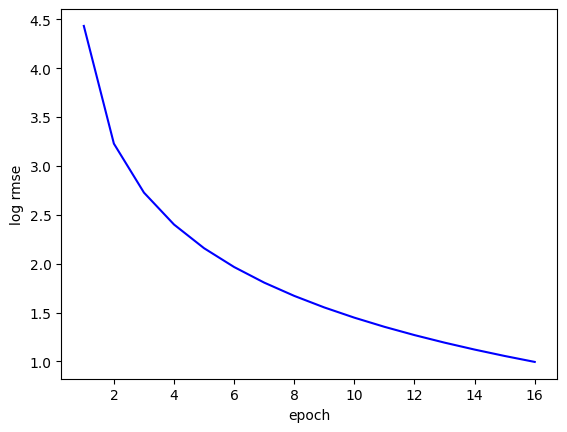

Loss in epoch 16 is 0.9941749274730682


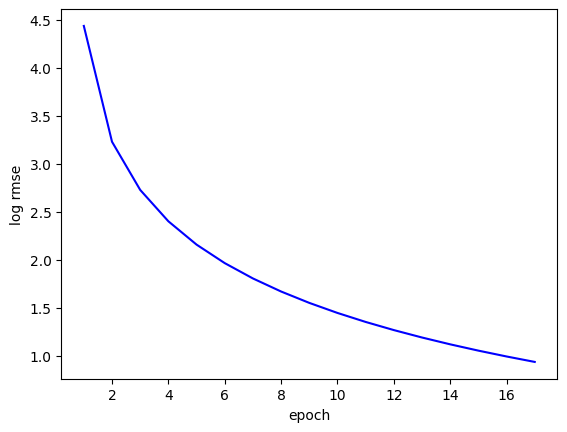

Loss in epoch 17 is 0.9375027596950531


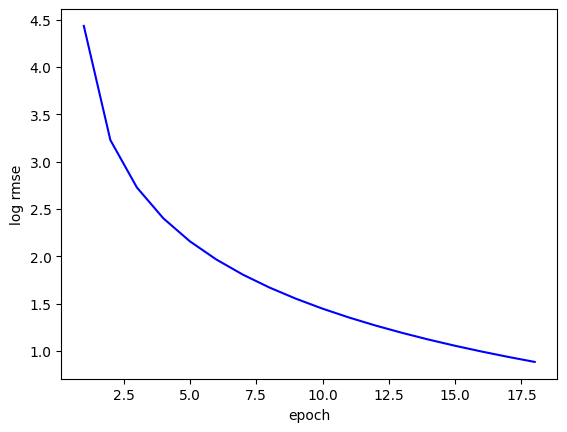

Loss in epoch 18 is 0.8845456838607788


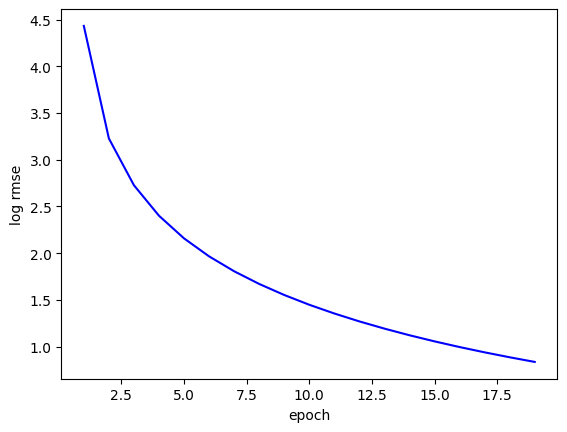

Loss in epoch 19 is 0.8348692238330842


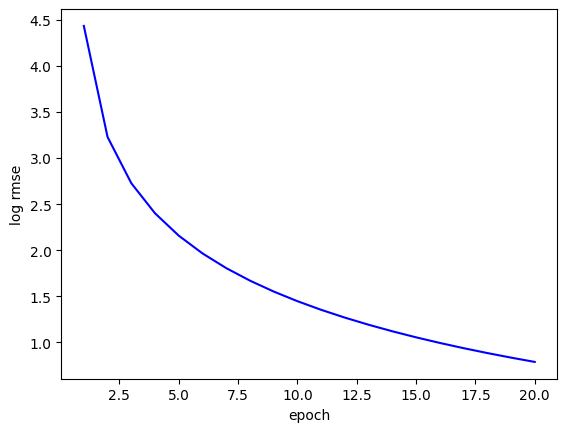

Loss in epoch 20 is 0.788141405582428


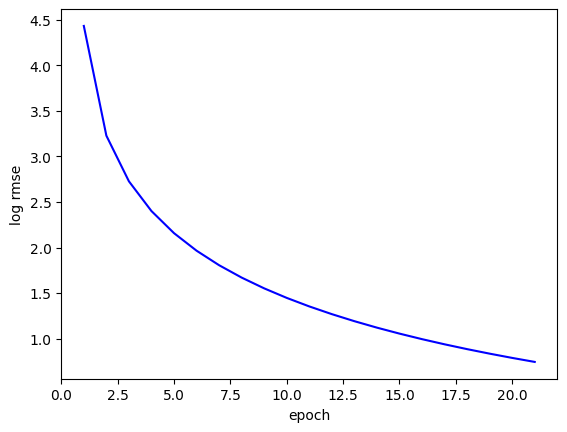

Loss in epoch 21 is 0.7440818130970002


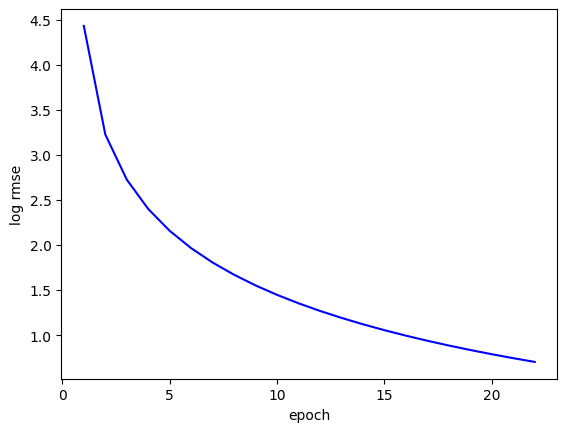

Loss in epoch 22 is 0.702513724565506


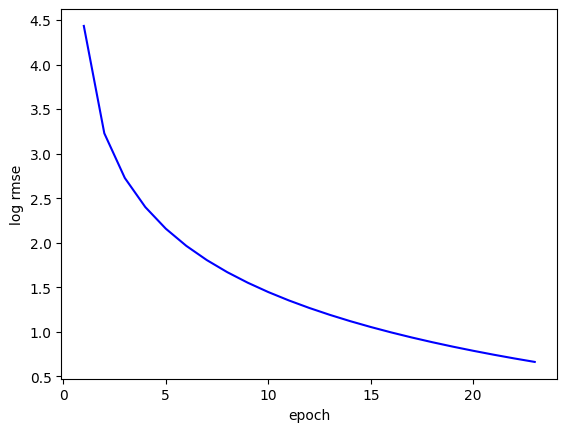

Loss in epoch 23 is 0.6632012128829956


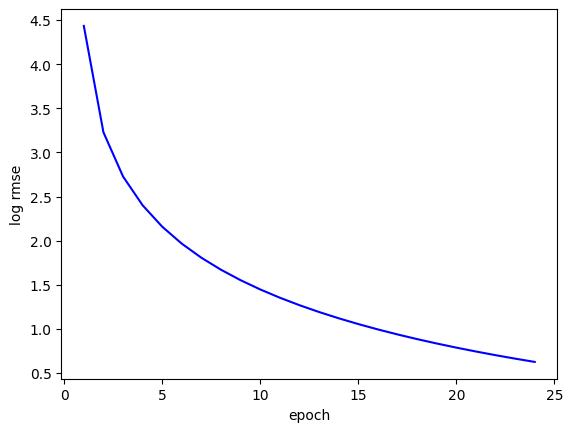

Loss in epoch 24 is 0.6259842813014984


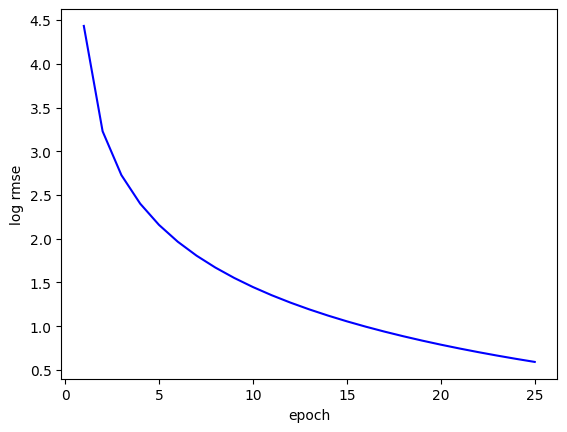

Loss in epoch 25 is 0.59074165225029


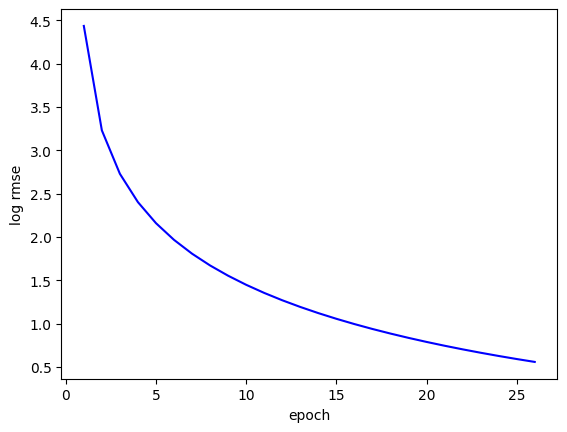

Loss in epoch 26 is 0.557339346408844


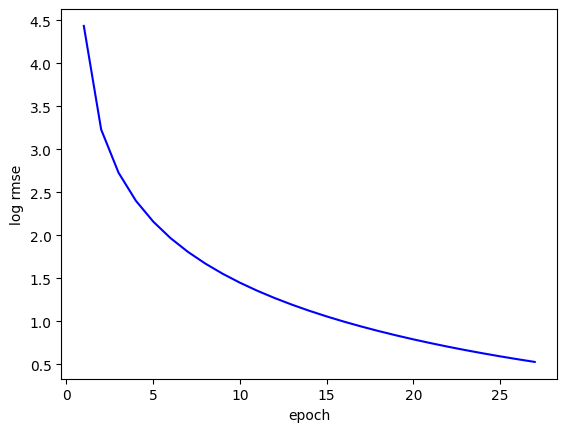

Loss in epoch 27 is 0.5256554841995239


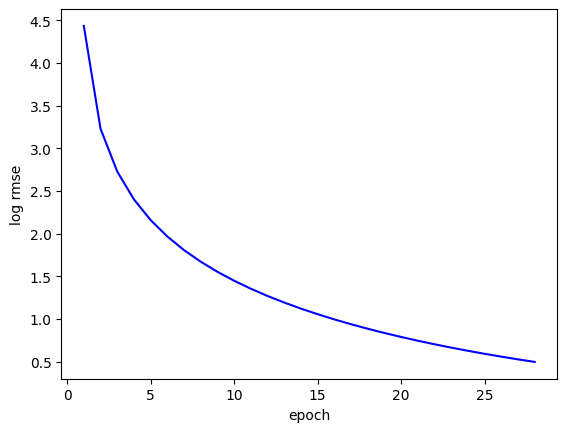

Loss in epoch 28 is 0.49565930664539337


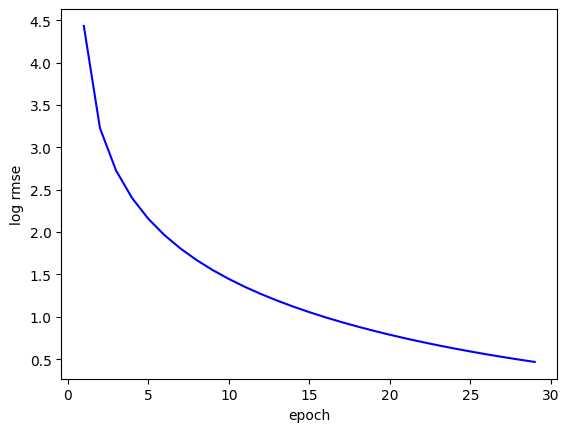

Loss in epoch 29 is 0.46727125346660614


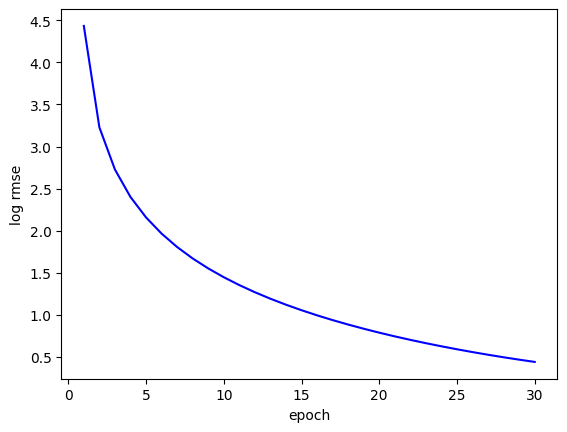

Loss in epoch 30 is 0.4404139220714569


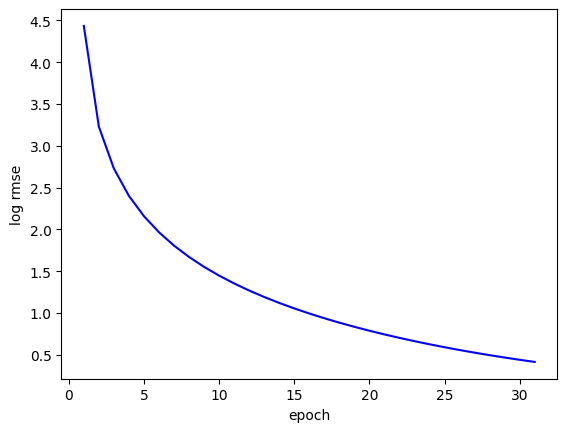

Loss in epoch 31 is 0.41499205827713015


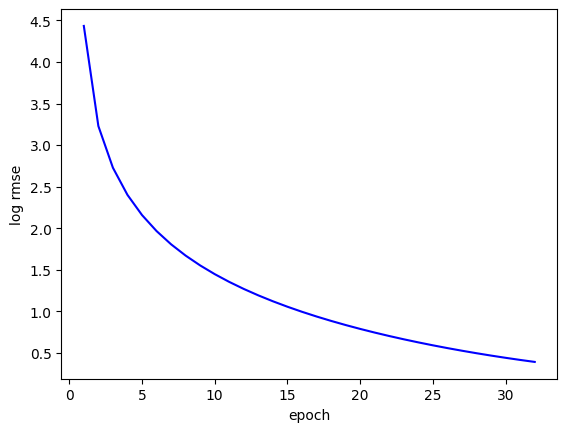

Loss in epoch 32 is 0.39104604423046113


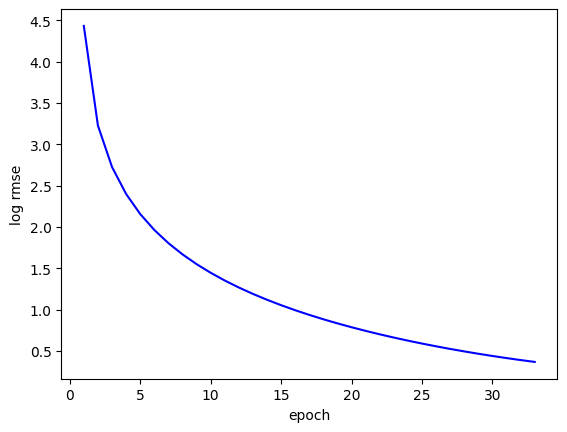

Loss in epoch 33 is 0.3685313403606415


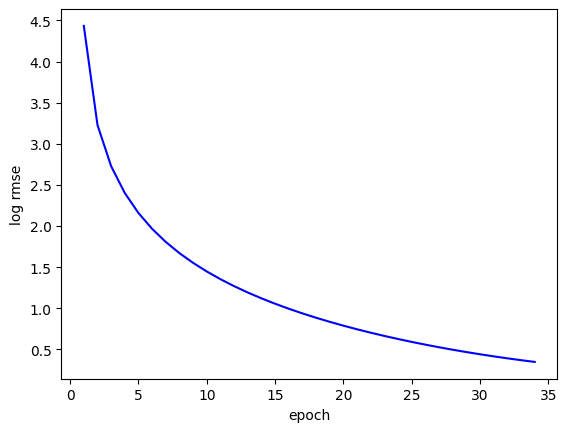

Loss in epoch 34 is 0.34739096462726593


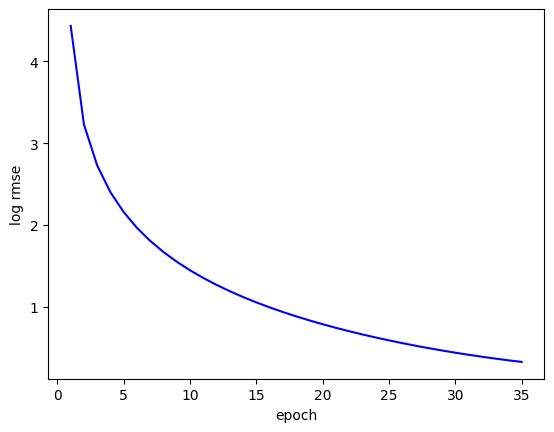

Loss in epoch 35 is 0.32759026288986204


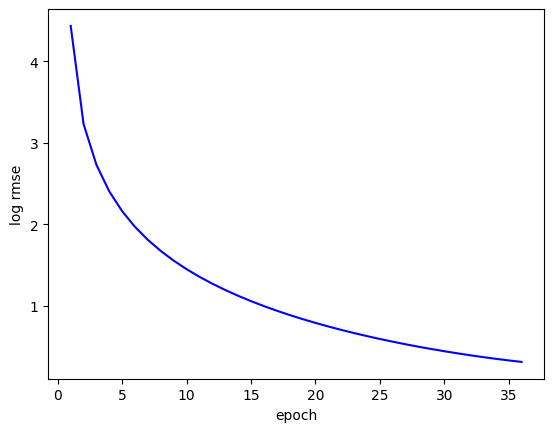

Loss in epoch 36 is 0.3091494470834732


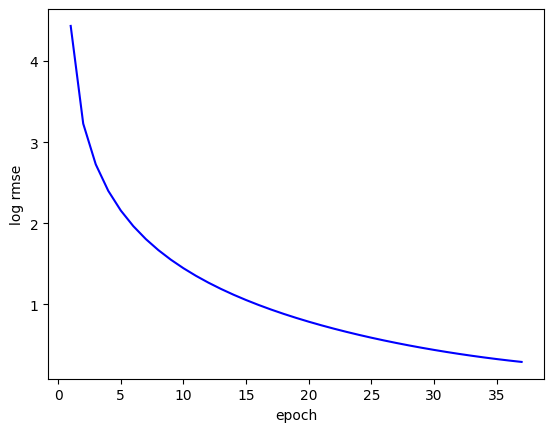

Loss in epoch 37 is 0.2921294003725052


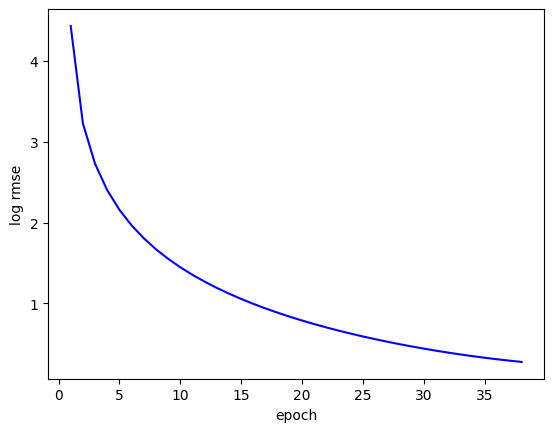

Loss in epoch 38 is 0.2764716580510139


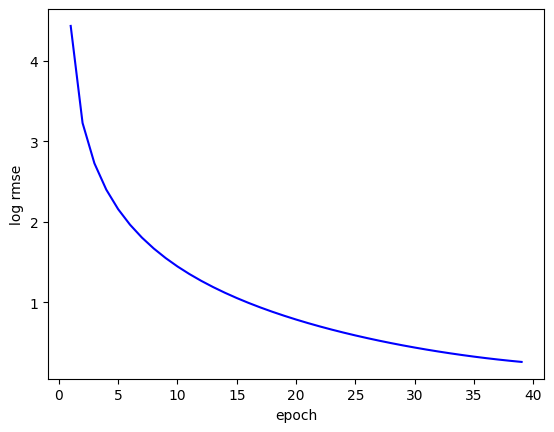

Loss in epoch 39 is 0.26212422996759416


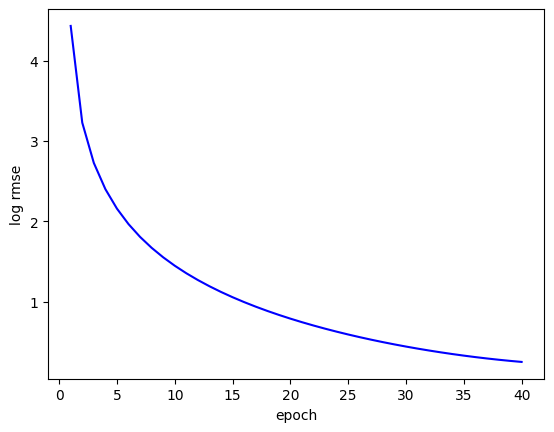

Loss in epoch 40 is 0.24910234063863754


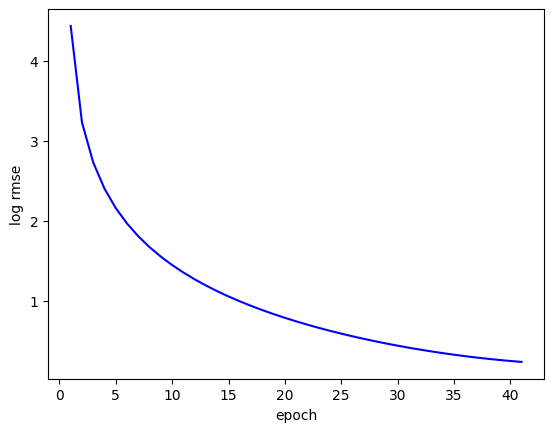

Loss in epoch 41 is 0.2374104455113411


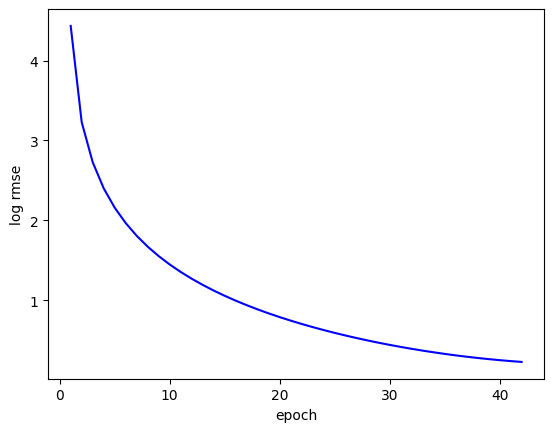

Loss in epoch 42 is 0.22700007855892182


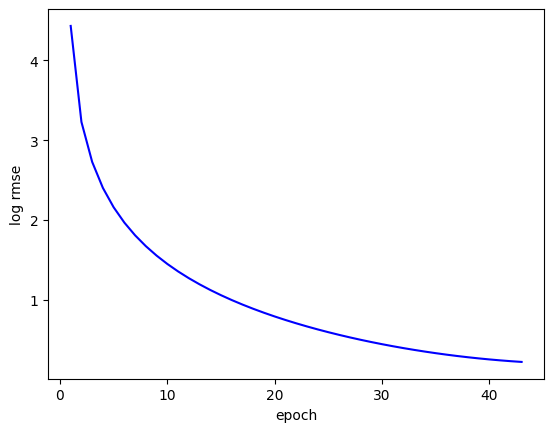

Loss in epoch 43 is 0.21782470643520355


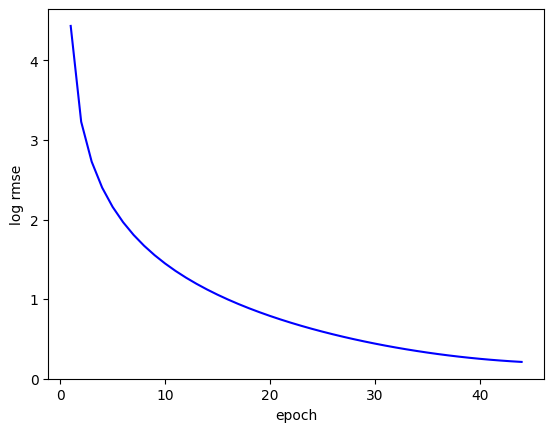

Loss in epoch 44 is 0.20982957929372786


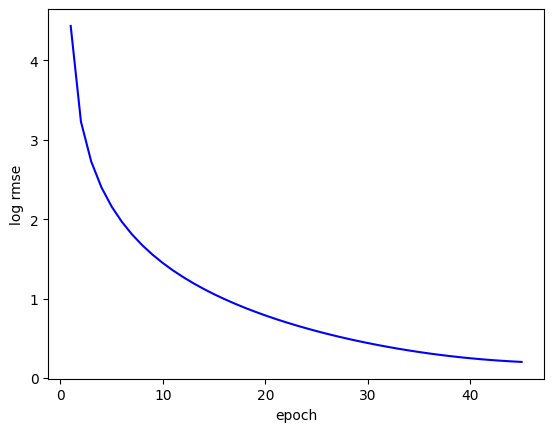

Loss in epoch 45 is 0.20296706557273864


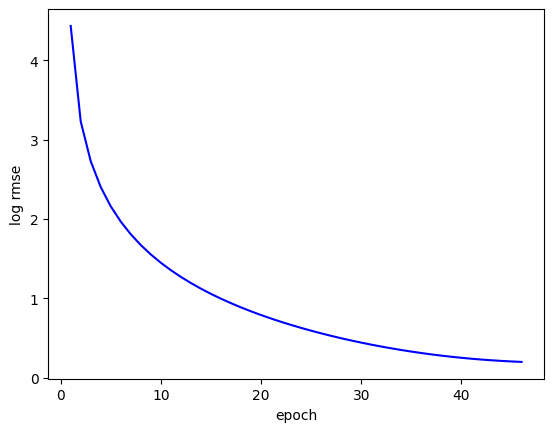

Loss in epoch 46 is 0.1971757099032402


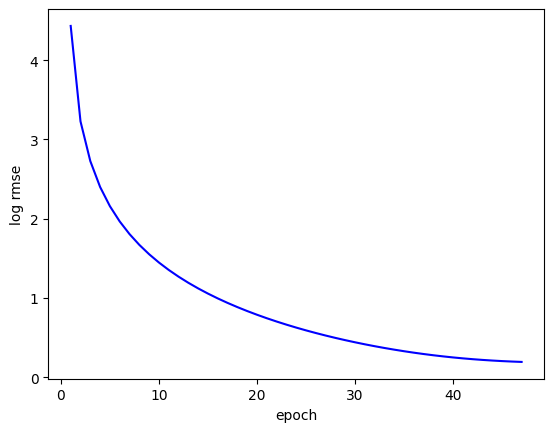

Loss in epoch 47 is 0.19237113893032073


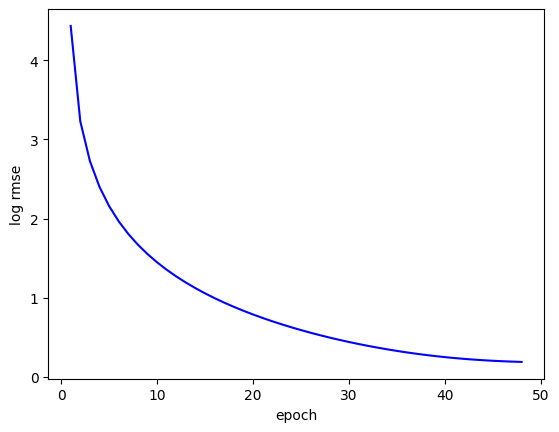

Loss in epoch 48 is 0.1884252592921257


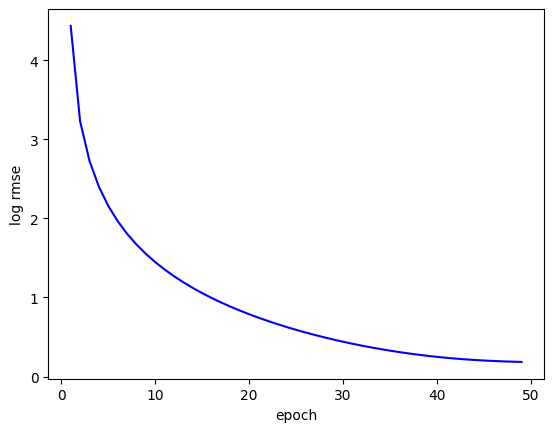

Loss in epoch 49 is 0.18525454849004747


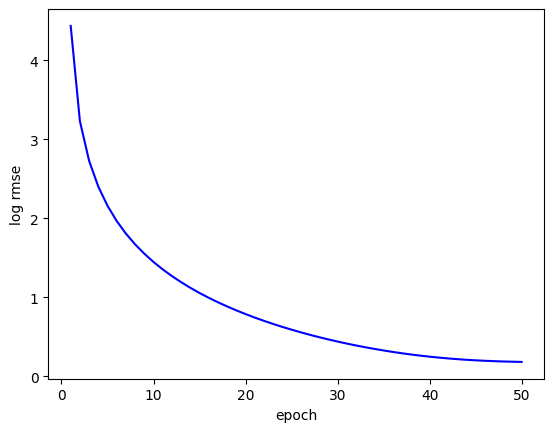

Loss in epoch 50 is 0.18274936079978943


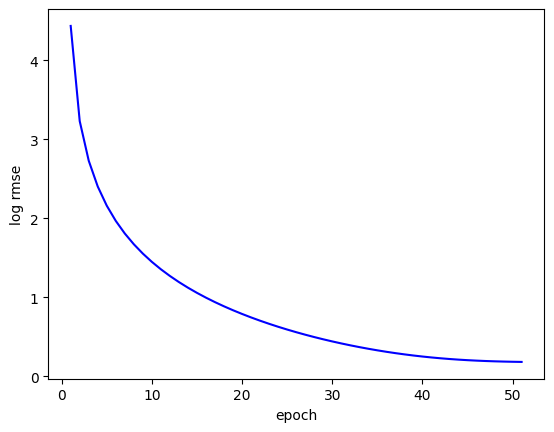

Loss in epoch 51 is 0.180840365588665


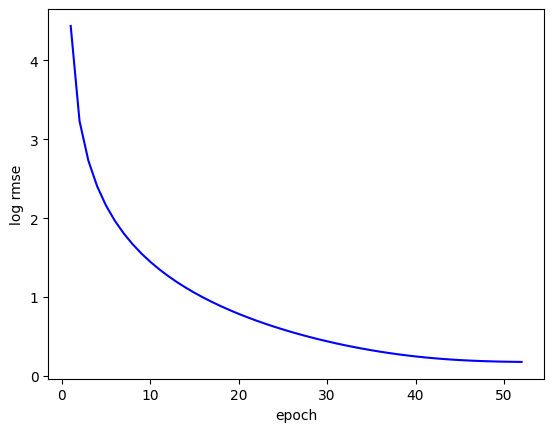

Loss in epoch 52 is 0.1794464409351349


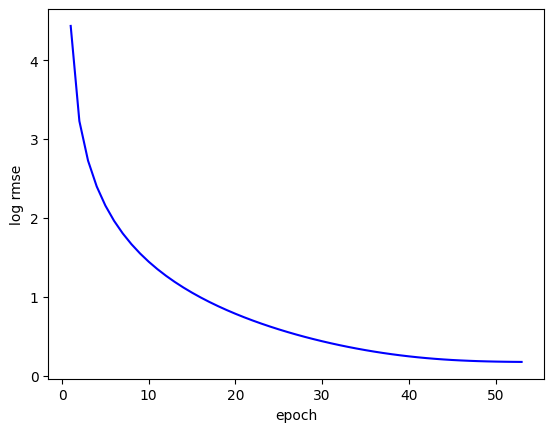

Loss in epoch 53 is 0.17851255536079408


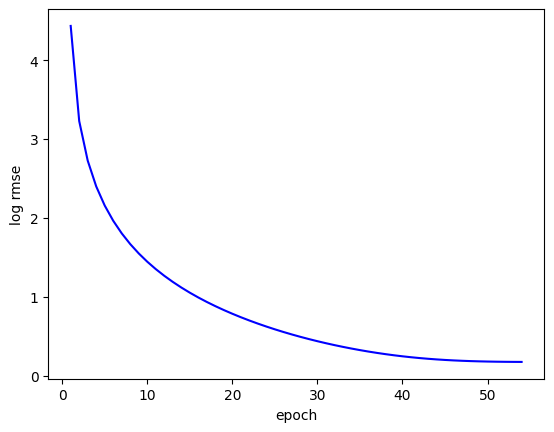

Loss in epoch 54 is 0.17798493057489395


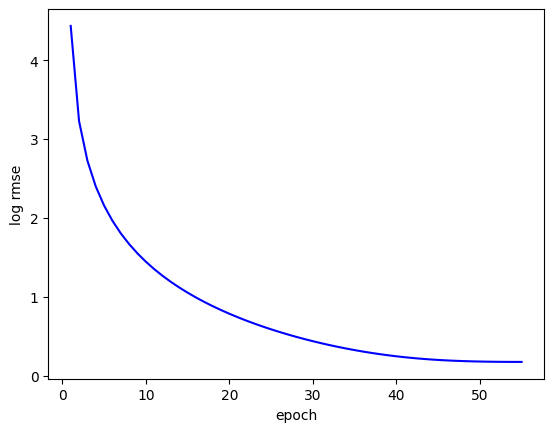

Loss in epoch 55 is 0.17782801985740662


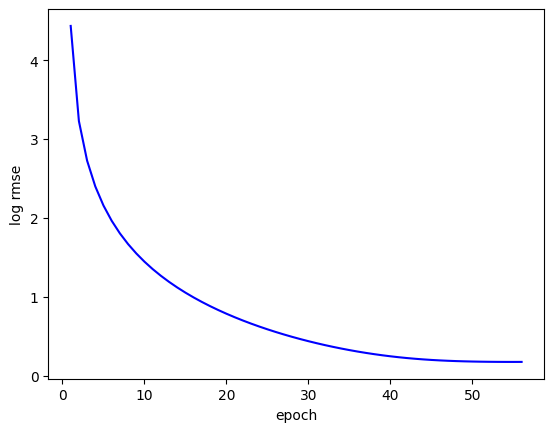

Loss in epoch 56 is 0.17812258303165435


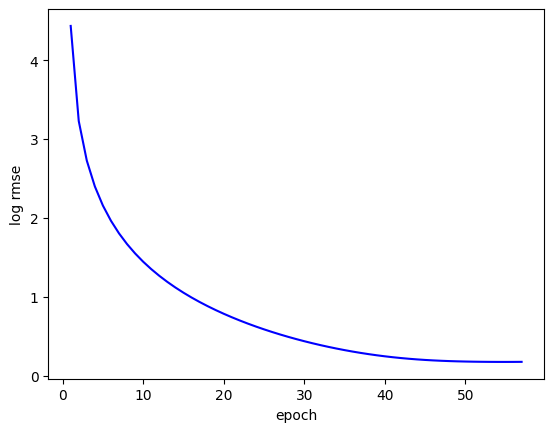

Loss in epoch 57 is 0.17880351841449738


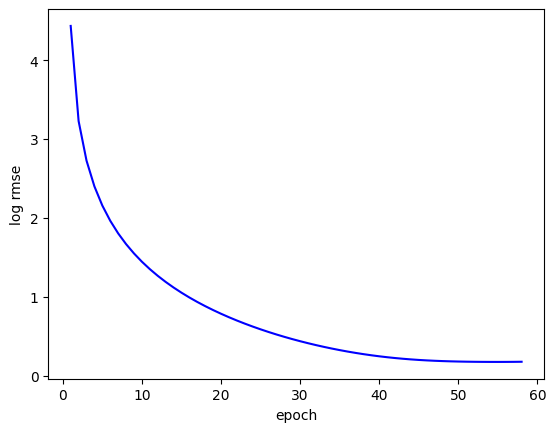

Loss in epoch 58 is 0.17992762625217437


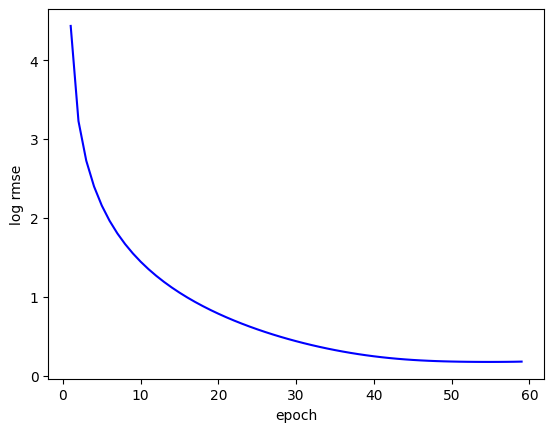

Loss in epoch 59 is 0.18183538615703582


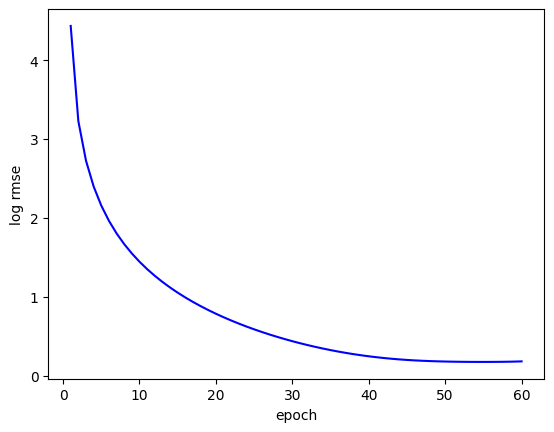

Loss in epoch 60 is 0.18478622734546662


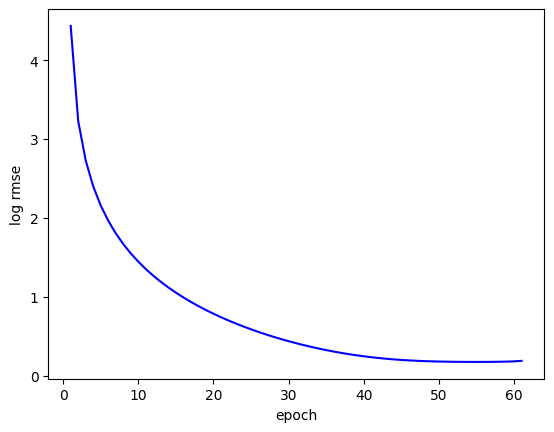

Loss in epoch 61 is 0.19148914963006974


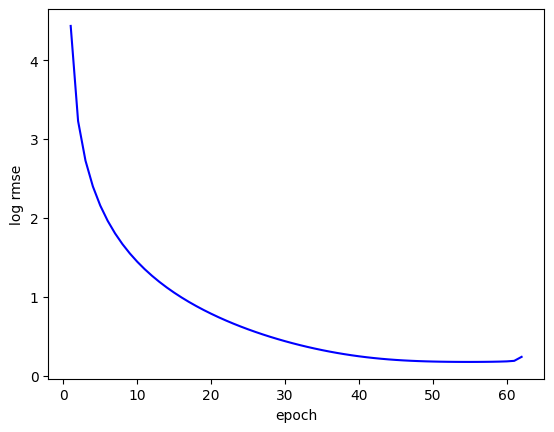

Loss in epoch 62 is 0.24199319034814834


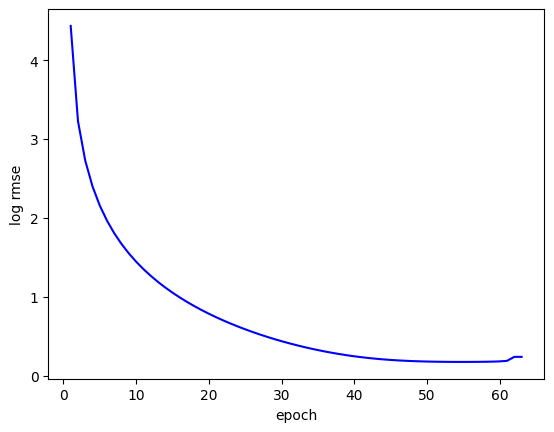

Loss in epoch 63 is 0.2419556513428688


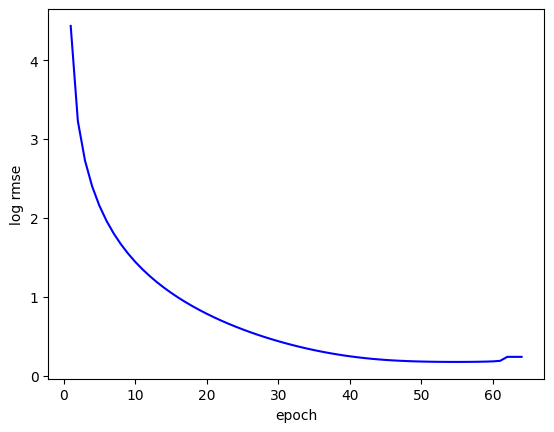

Loss in epoch 64 is 0.24190516769886017


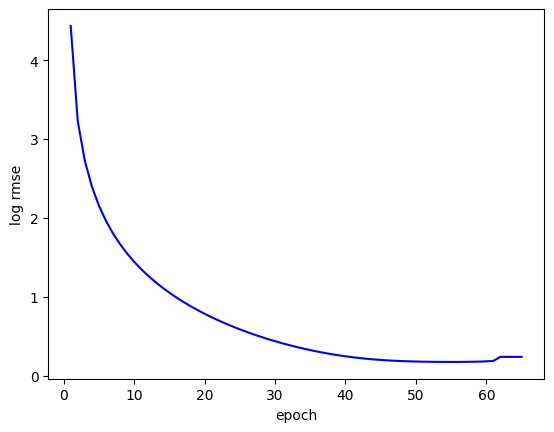

Loss in epoch 65 is 0.24185515493154525


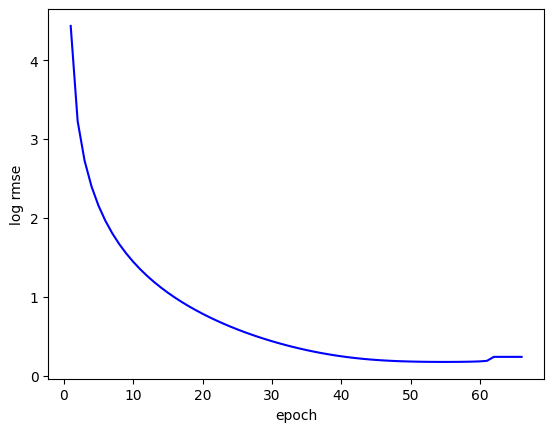

Loss in epoch 66 is 0.24178274124860763


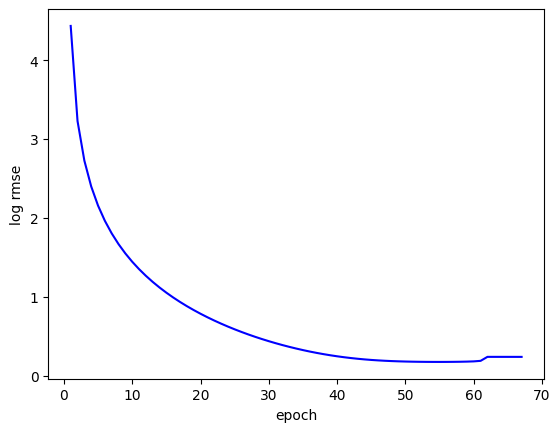

Loss in epoch 67 is 0.24166826009750367


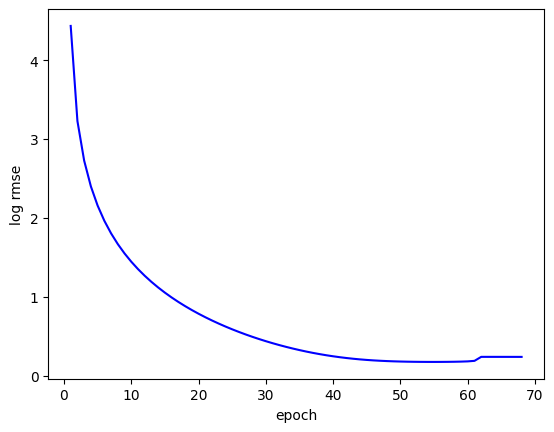

Loss in epoch 68 is 0.2415373831987381


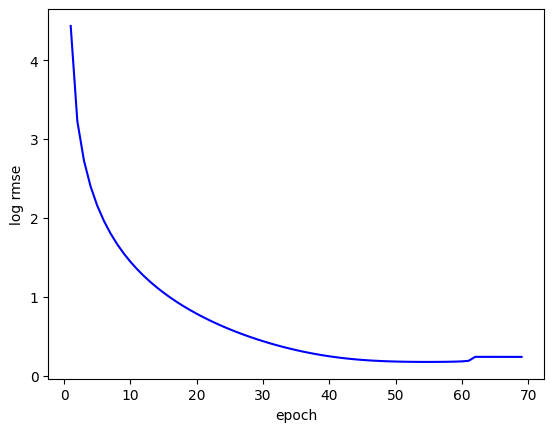

Loss in epoch 69 is 0.24140450805425645


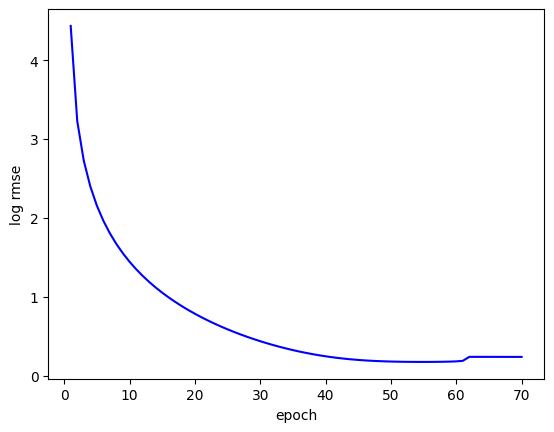

Loss in epoch 70 is 0.24127038419246674


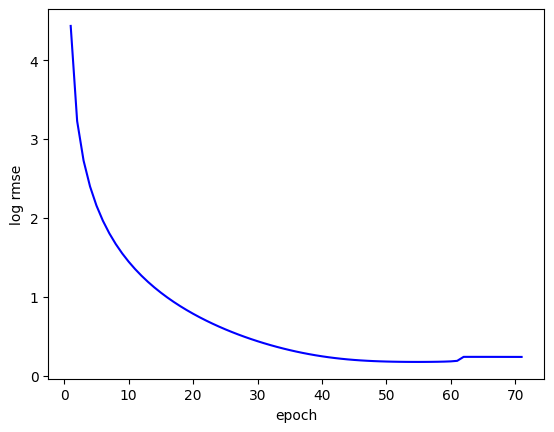

Loss in epoch 71 is 0.24106243401765823


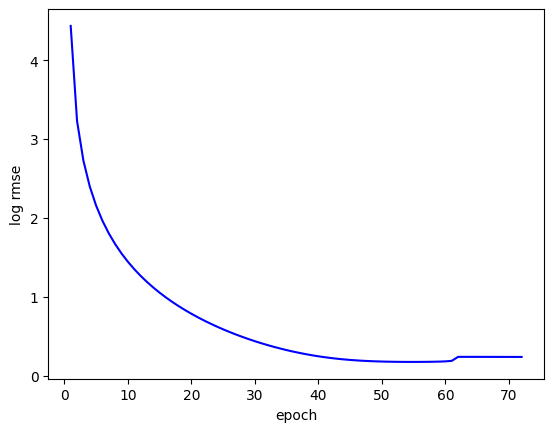

Loss in epoch 72 is 0.24082063883543015


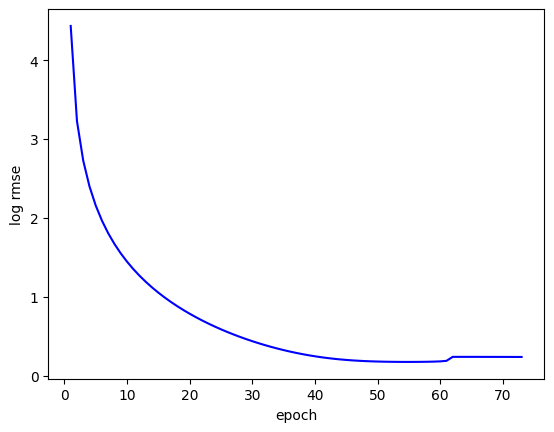

Loss in epoch 73 is 0.24055988490581512


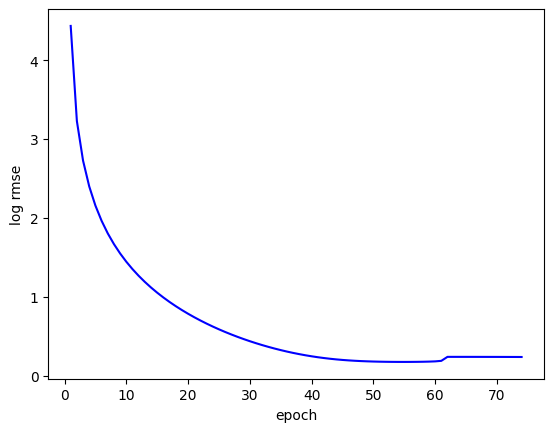

Loss in epoch 74 is 0.24025849401950836


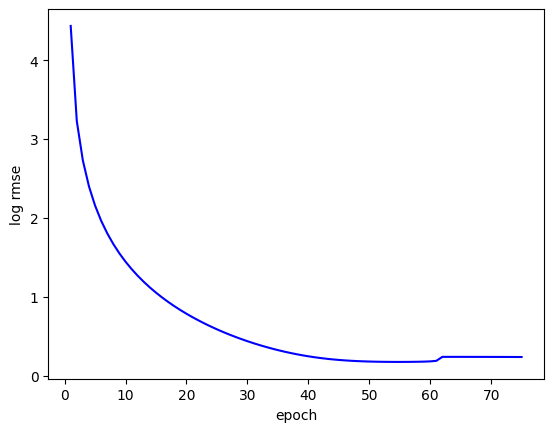

Loss in epoch 75 is 0.23999880254268646


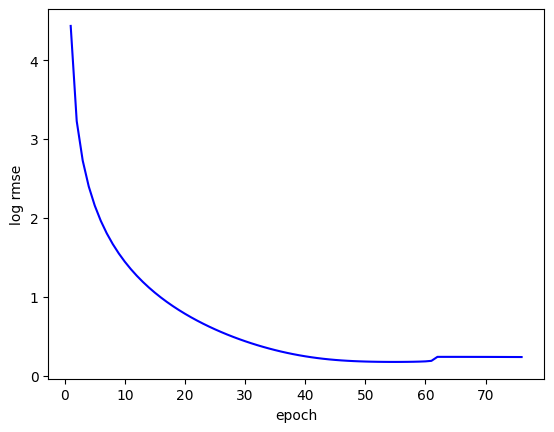

Loss in epoch 76 is 0.23966374844312668


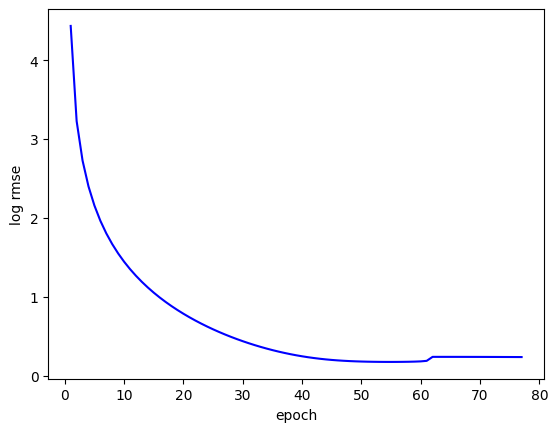

Loss in epoch 77 is 0.2393660292029381


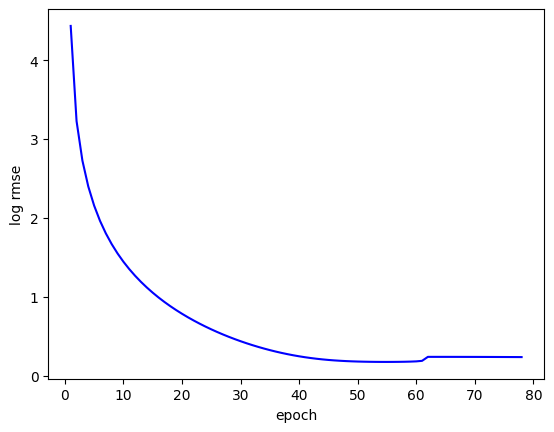

Loss in epoch 78 is 0.2389715313911438


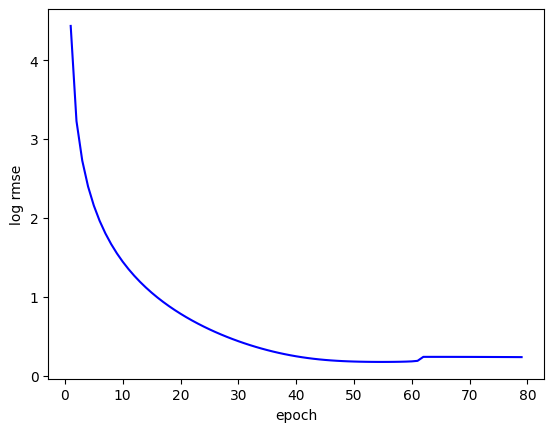

Loss in epoch 79 is 0.2385910227894783


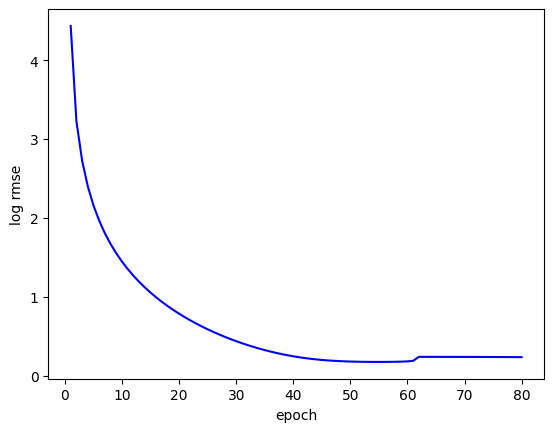

Loss in epoch 80 is 0.23820738047361373


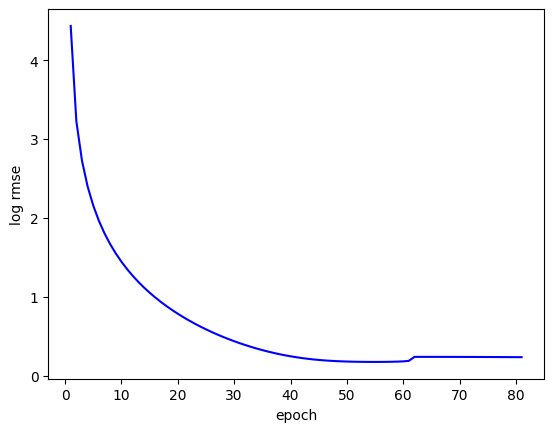

Loss in epoch 81 is 0.2378695785999298


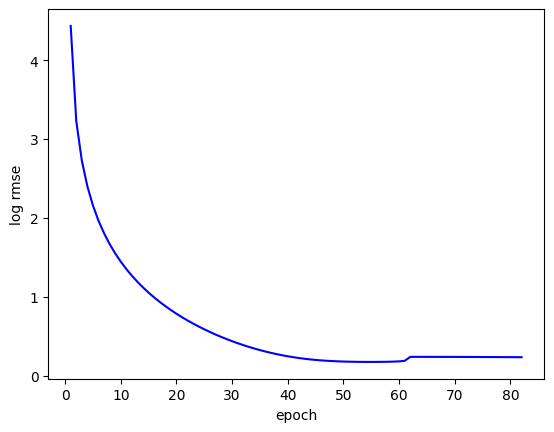

Loss in epoch 82 is 0.23751555234193802


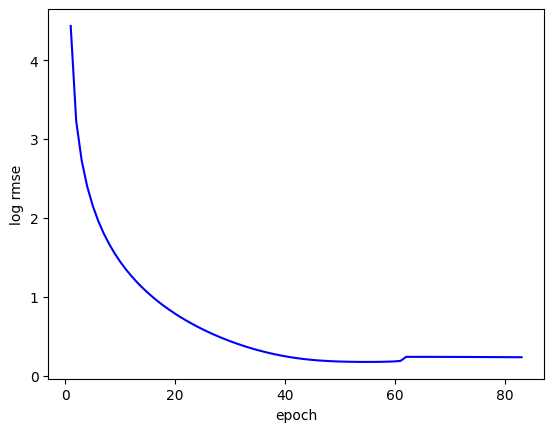

Loss in epoch 83 is 0.23723479062318803


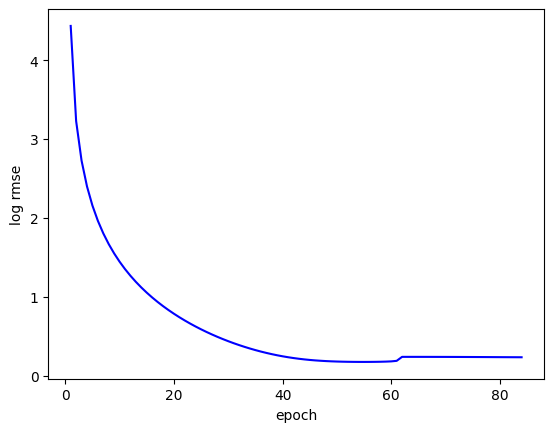

Loss in epoch 84 is 0.23687290102243425


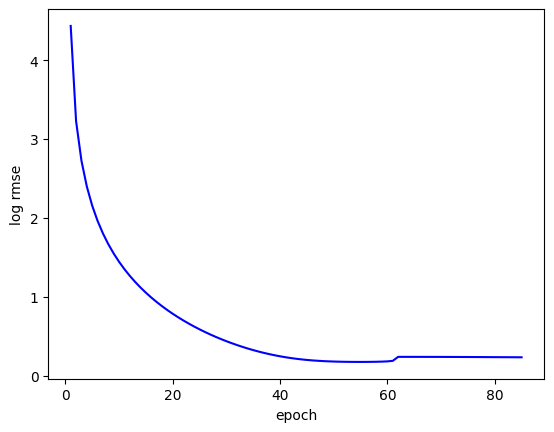

Loss in epoch 85 is 0.23651382625102996


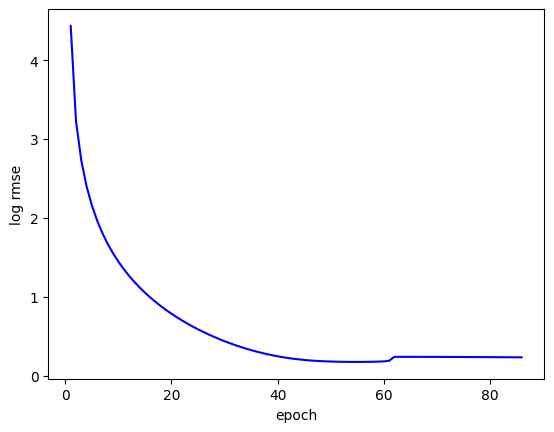

Loss in epoch 86 is 0.23611485064029694


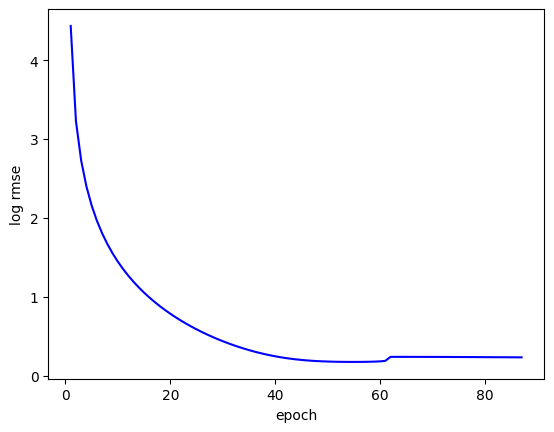

Loss in epoch 87 is 0.23581110686063766


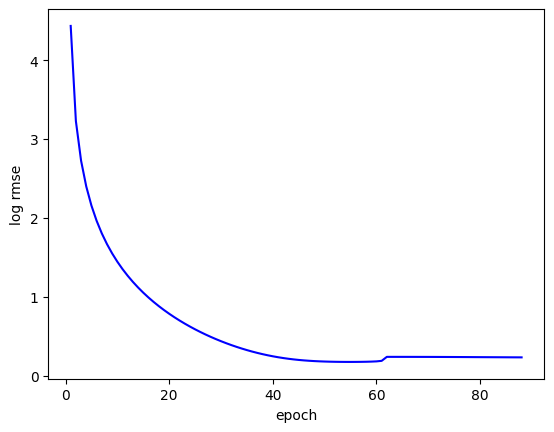

Loss in epoch 88 is 0.23549998551607132


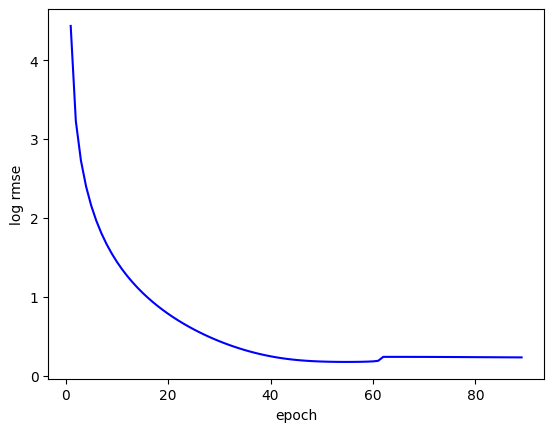

Loss in epoch 89 is 0.2351797789335251


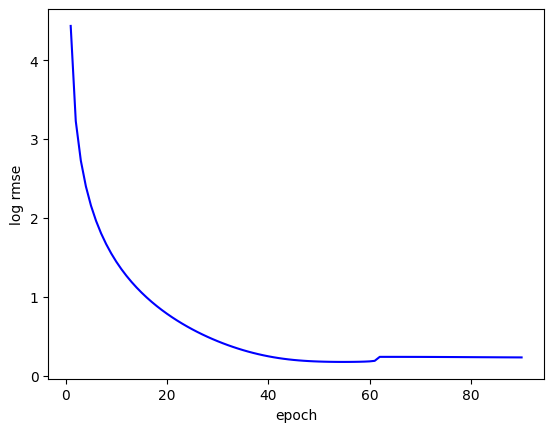

Loss in epoch 90 is 0.23489513993263245


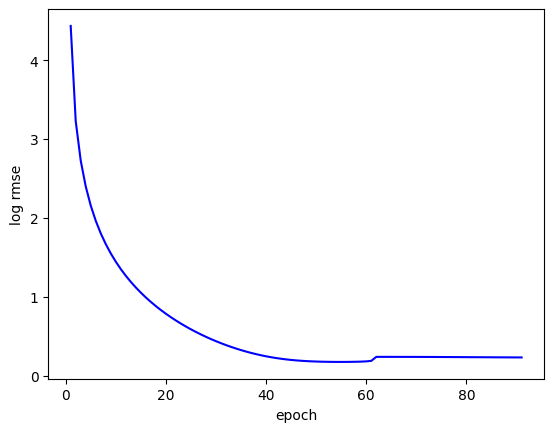

Loss in epoch 91 is 0.2345953494310379


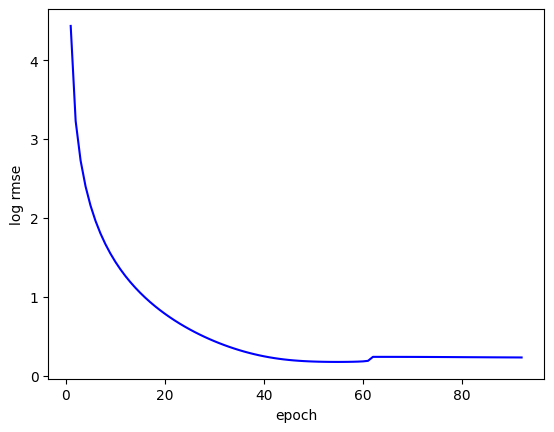

Loss in epoch 92 is 0.23421995341777802


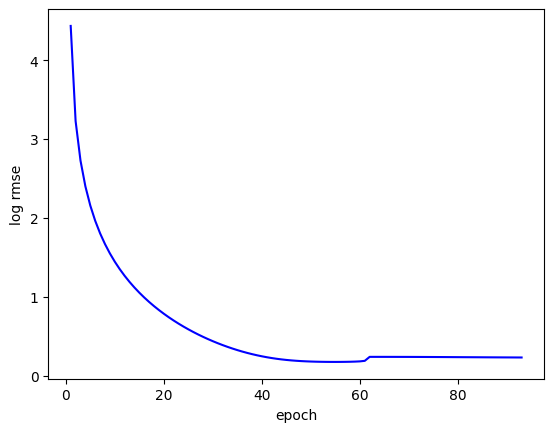

Loss in epoch 93 is 0.23395513743162155


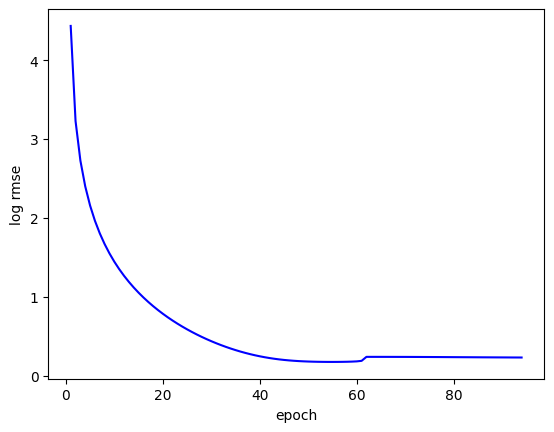

Loss in epoch 94 is 0.23367366716265678


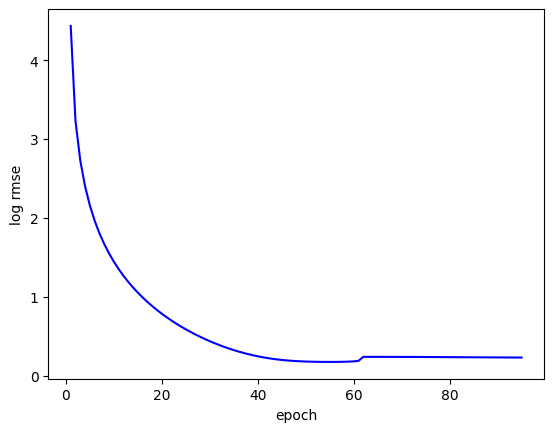

Loss in epoch 95 is 0.23347683846950532


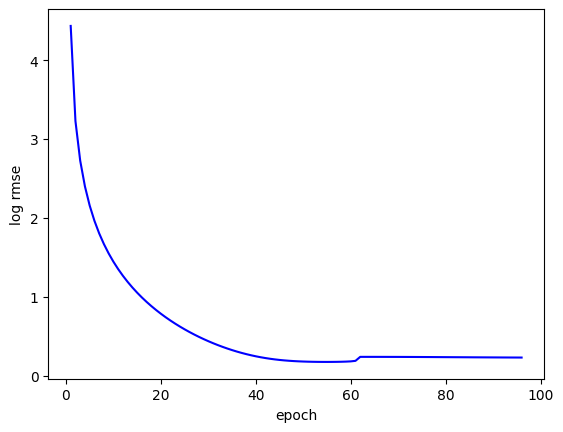

Loss in epoch 96 is 0.23319875448942184


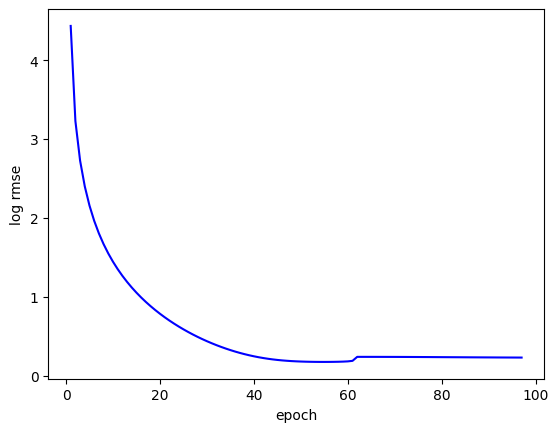

Loss in epoch 97 is 0.23293196484446527


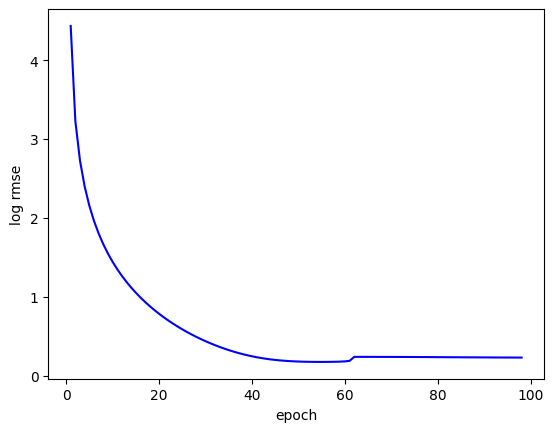

Loss in epoch 98 is 0.23266342133283616


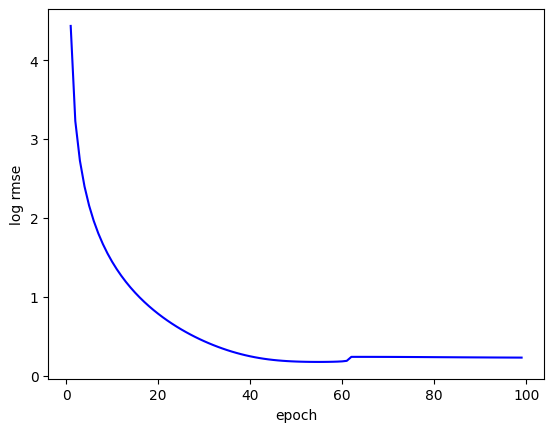

Loss in epoch 99 is 0.2324704945087433


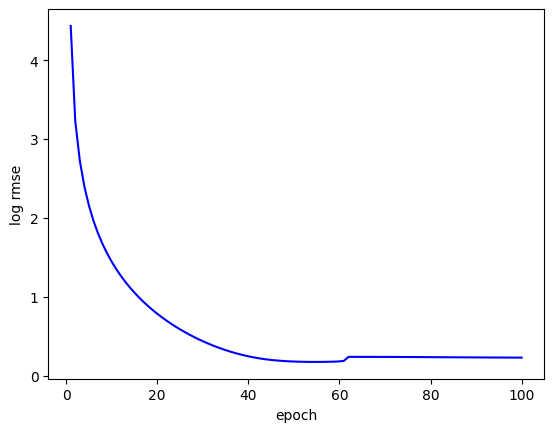

Loss in epoch 100 is 0.23217786177992822


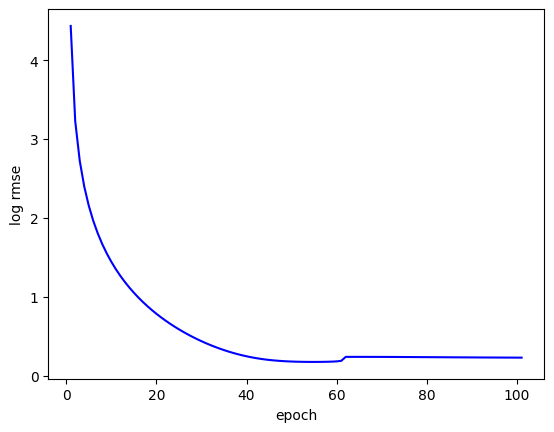

Loss in epoch 101 is 0.23194598257541657


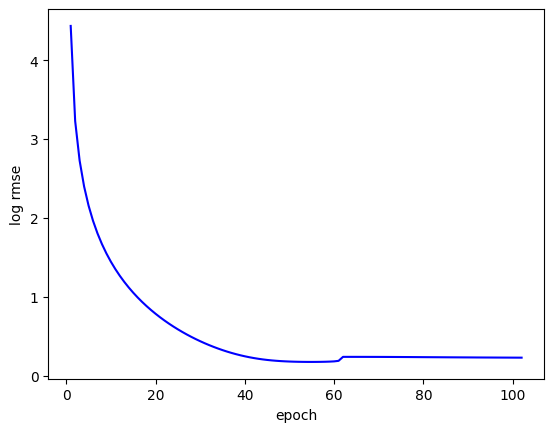

Loss in epoch 102 is 0.23179641962051392


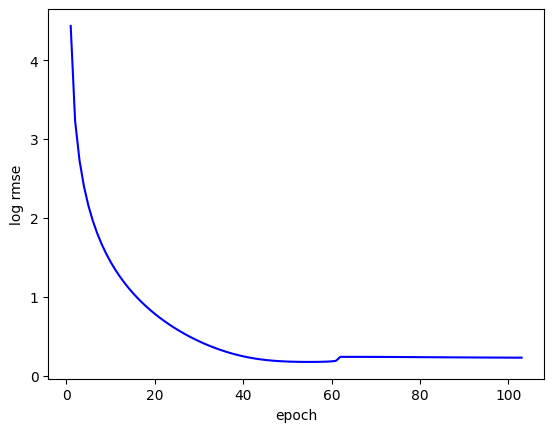

Loss in epoch 103 is 0.23157725110650063


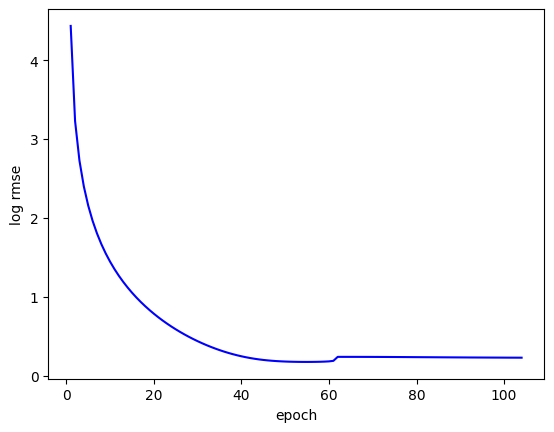

Loss in epoch 104 is 0.23146365731954574


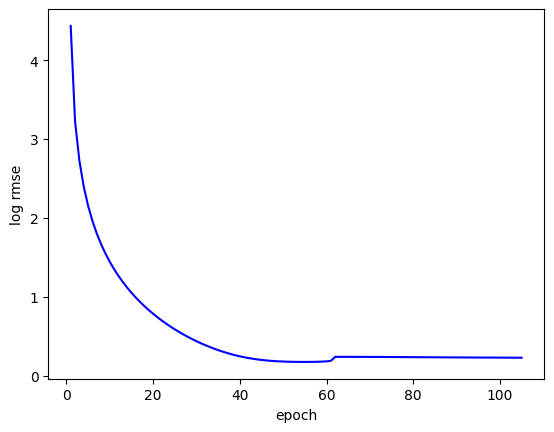

Loss in epoch 105 is 0.23128703683614732


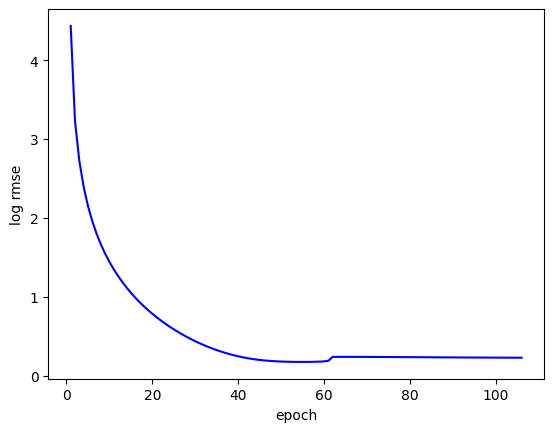

Loss in epoch 106 is 0.23106636255979537


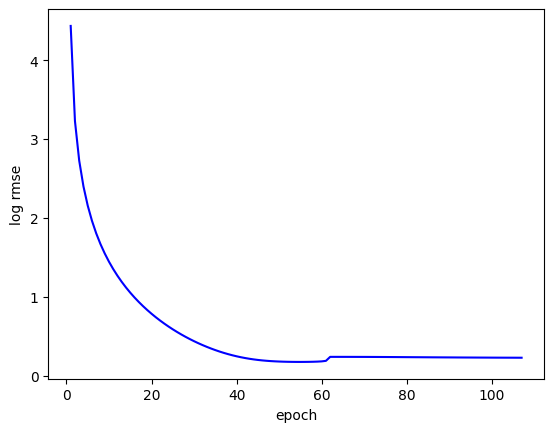

Loss in epoch 107 is 0.23088074550032617


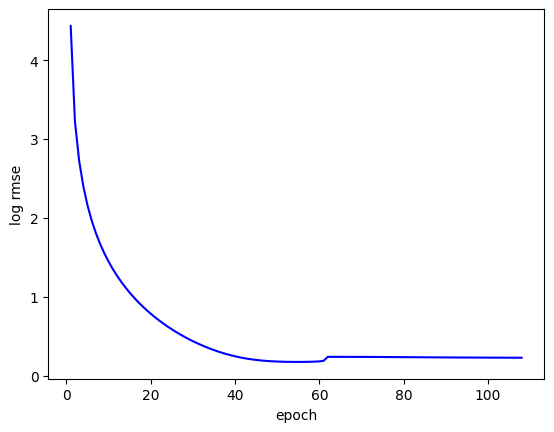

Loss in epoch 108 is 0.2307144097983837


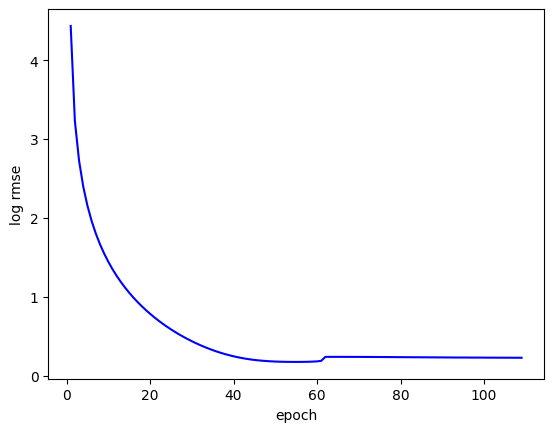

Loss in epoch 109 is 0.23057937175035476


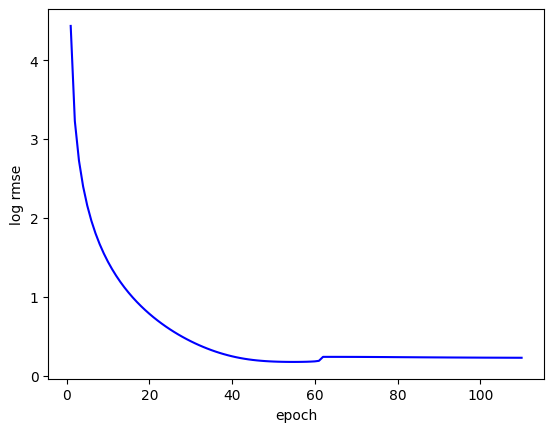

Loss in epoch 110 is 0.2304229512810707


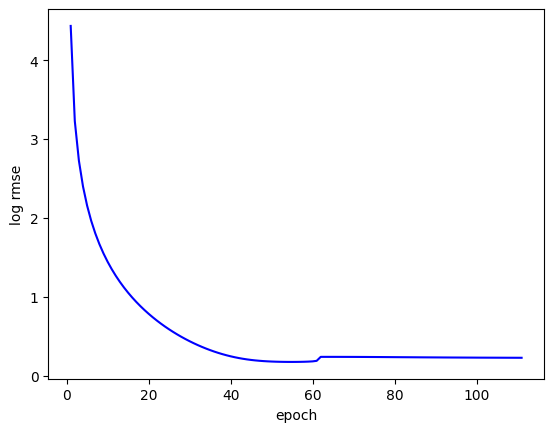

Loss in epoch 111 is 0.23024251237511634


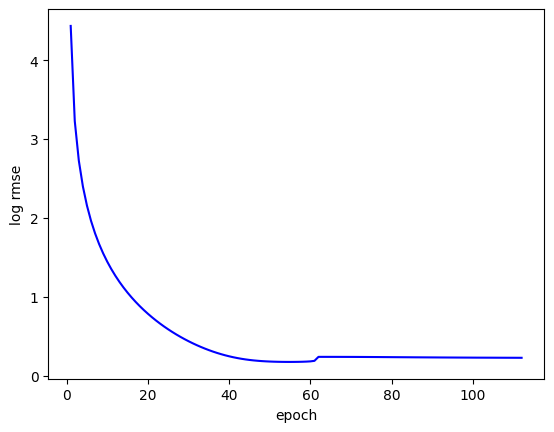

Loss in epoch 112 is 0.23004997596144677


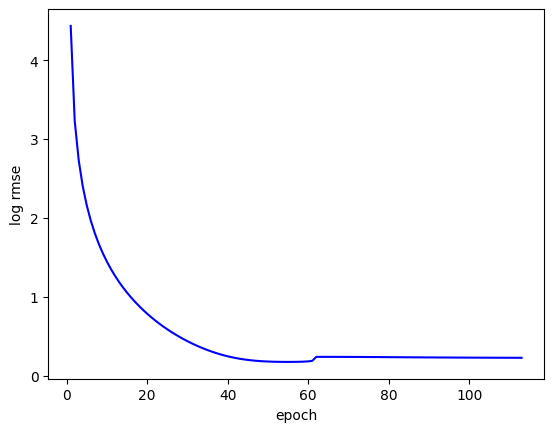

Loss in epoch 113 is 0.2298690177500248


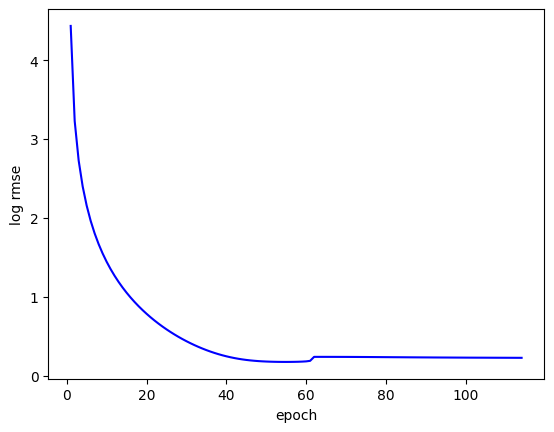

Loss in epoch 114 is 0.22974225804209708


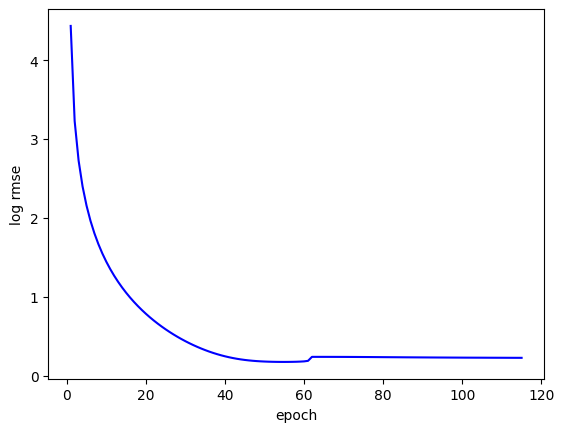

Loss in epoch 115 is 0.2296291060745716


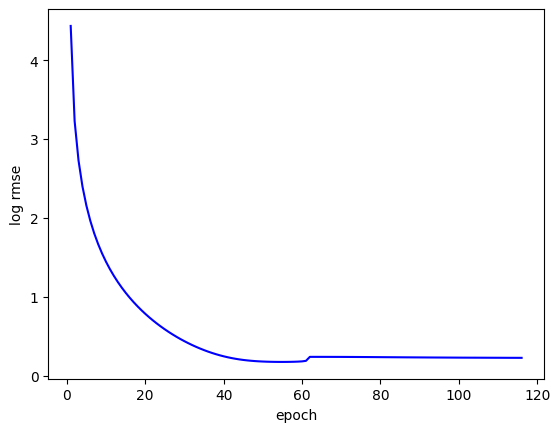

Loss in epoch 116 is 0.22953506112098693


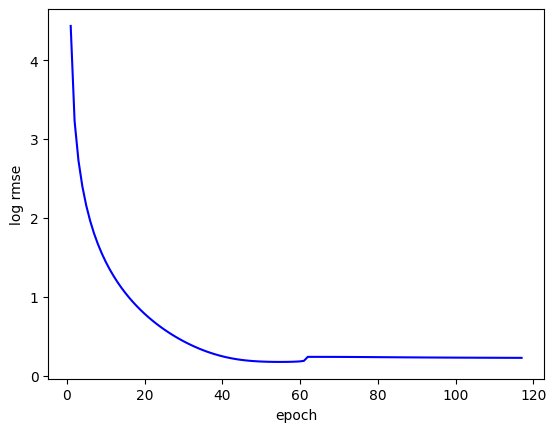

Loss in epoch 117 is 0.2293778657913208


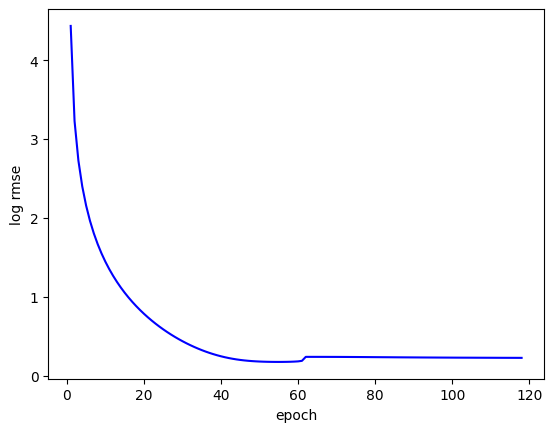

Loss in epoch 118 is 0.22922011688351632


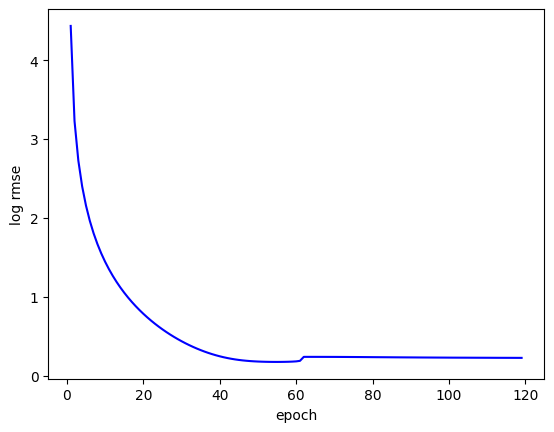

Loss in epoch 119 is 0.22908706739544868


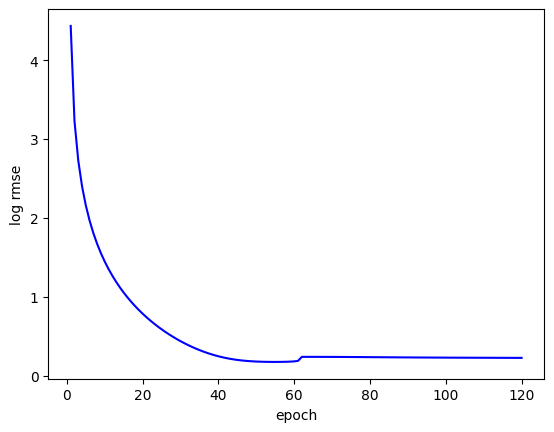

Loss in epoch 120 is 0.22897580415010452


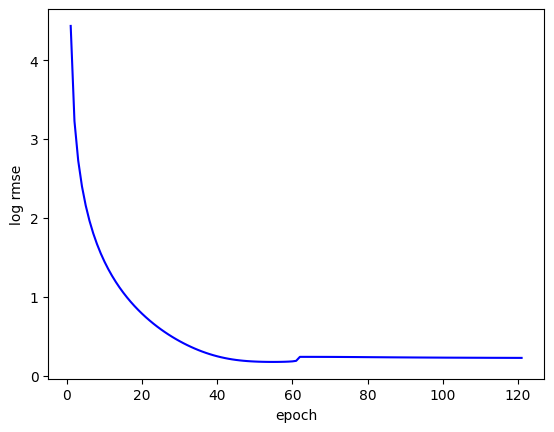

Loss in epoch 121 is 0.22884155586361885


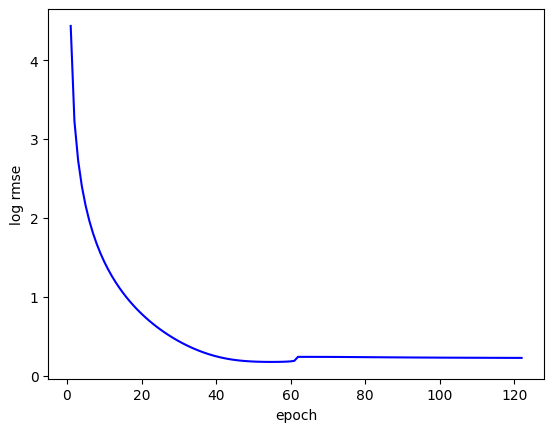

Loss in epoch 122 is 0.22868661880493163


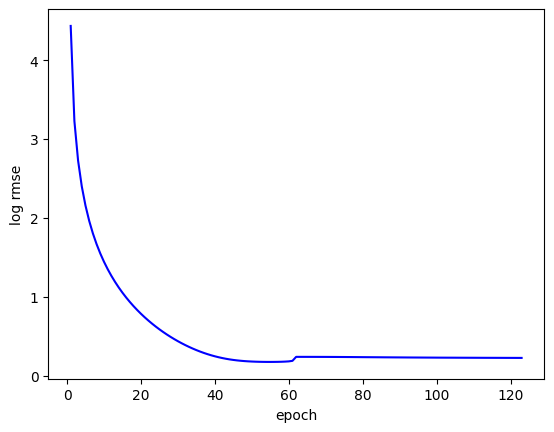

Loss in epoch 123 is 0.22860832288861274


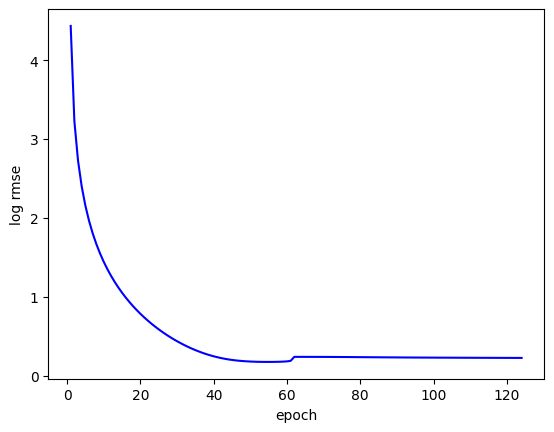

Loss in epoch 124 is 0.22851777374744414


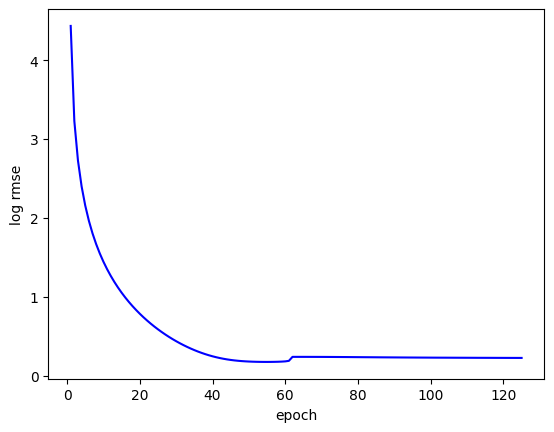

Loss in epoch 125 is 0.22850219830870627


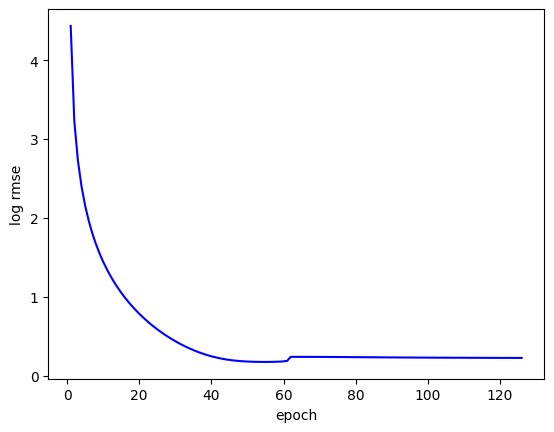

Loss in epoch 126 is 0.22839327827095984


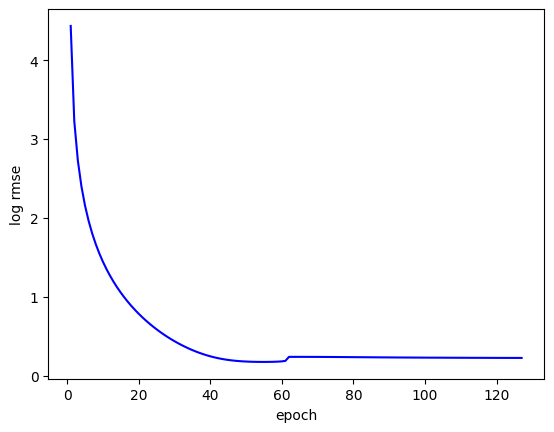

Loss in epoch 127 is 0.22826508730649947


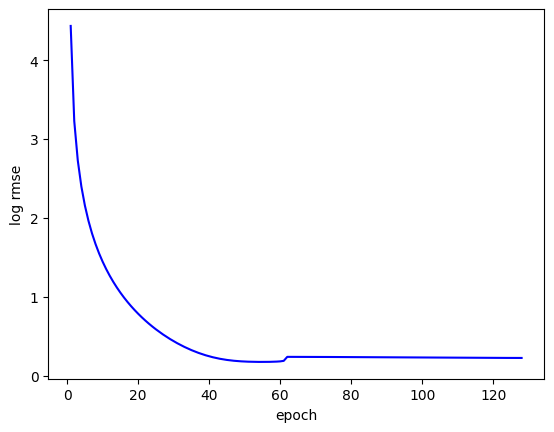

Loss in epoch 128 is 0.22815156280994414


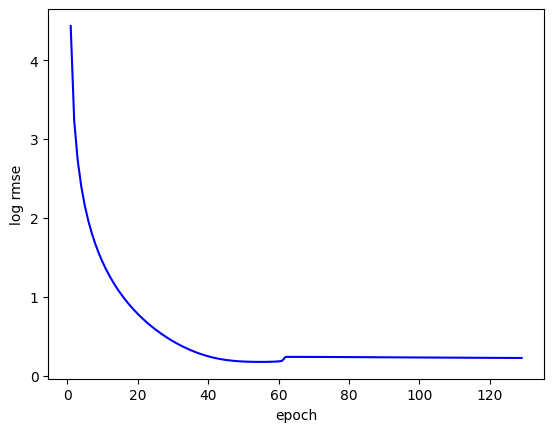

Loss in epoch 129 is 0.2281131215393543


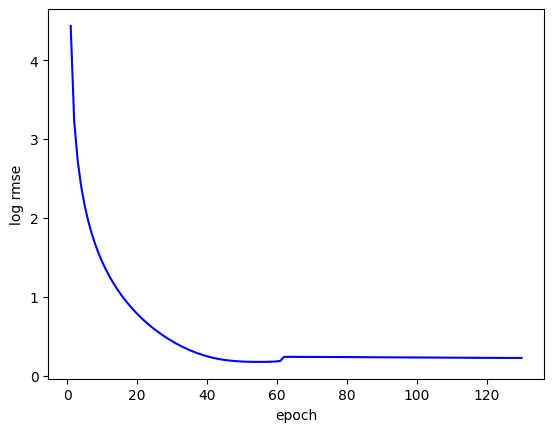

Loss in epoch 130 is 0.22802438884973525


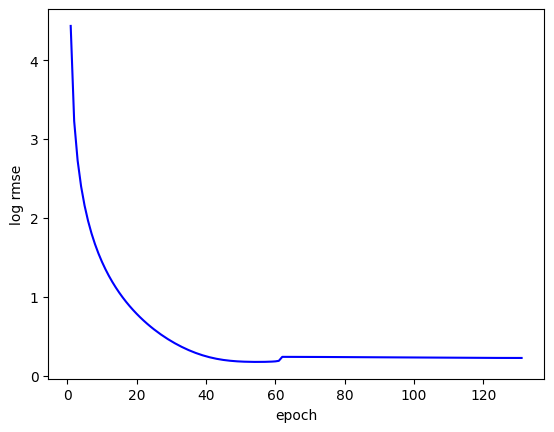

Loss in epoch 131 is 0.22801334261894227


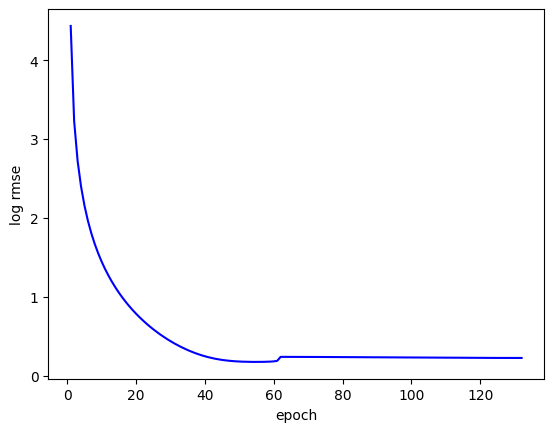

Loss in epoch 132 is 0.22792127653956412


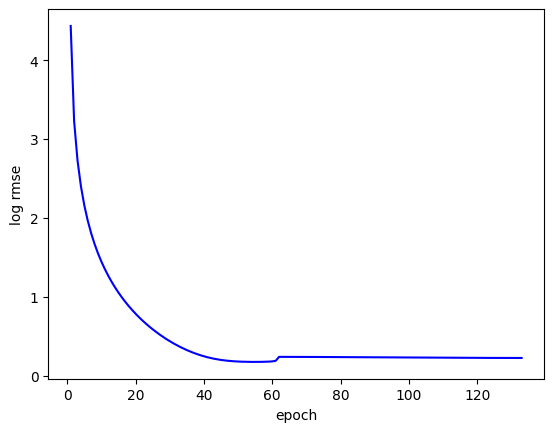

Loss in epoch 133 is 0.22787154093384743


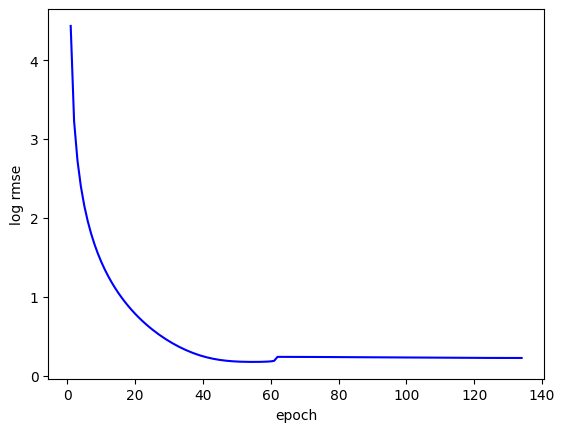

Loss in epoch 134 is 0.22776924446225166


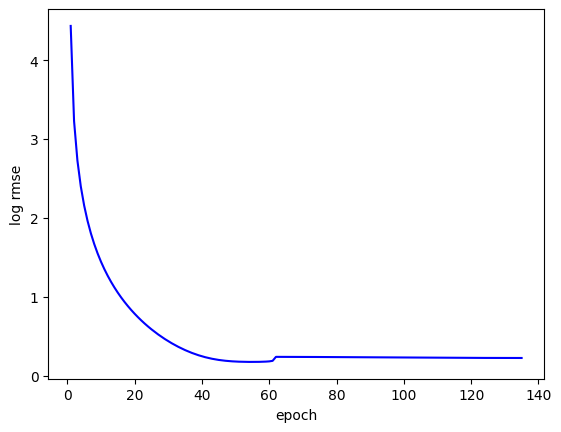

Loss in epoch 135 is 0.2276921845972538


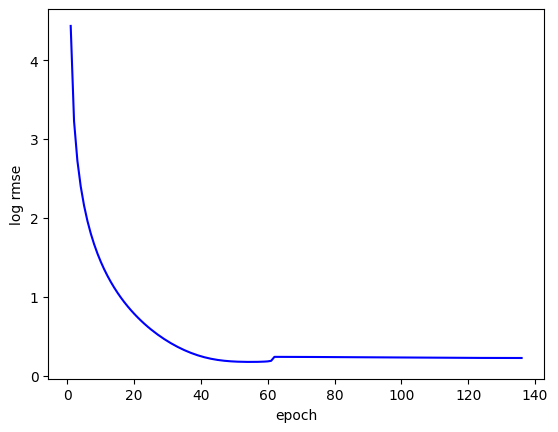

Loss in epoch 136 is 0.22756137251853942


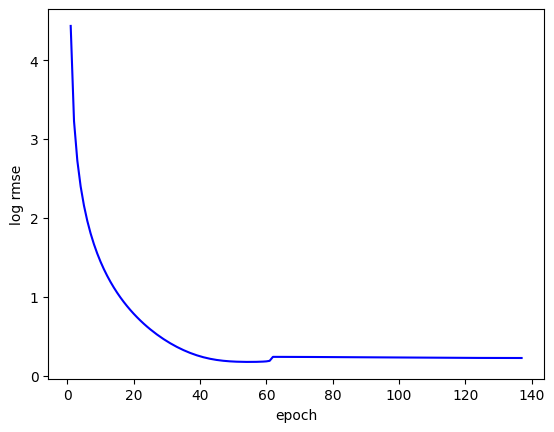

Loss in epoch 137 is 0.2274652823805809


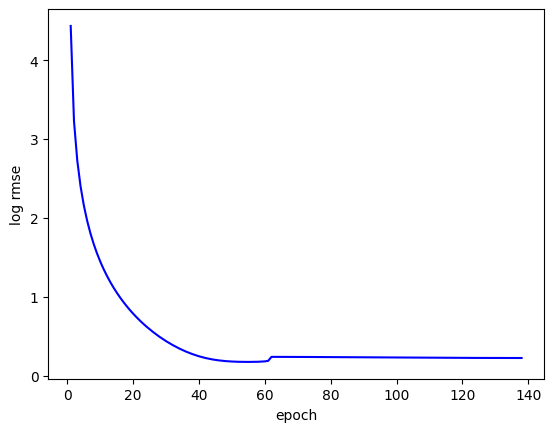

Loss in epoch 138 is 0.22736963853240014


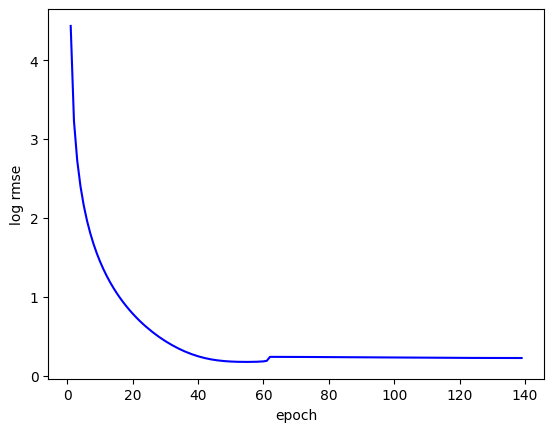

Loss in epoch 139 is 0.22727091684937478


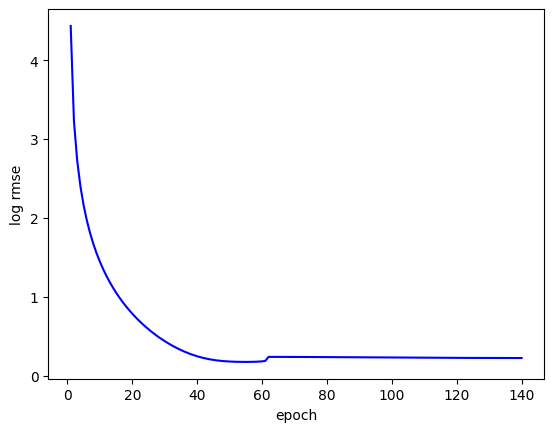

Loss in epoch 140 is 0.22723437696695328


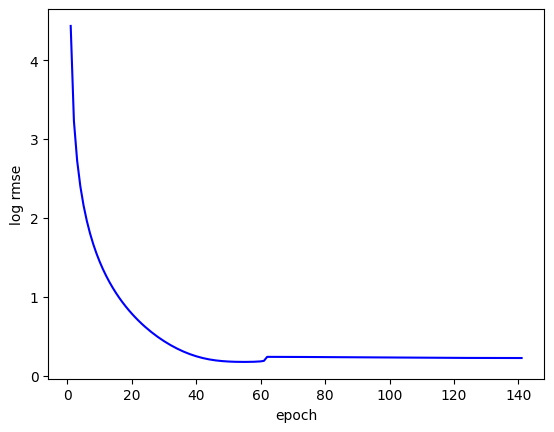

Loss in epoch 141 is 0.2271846517920494


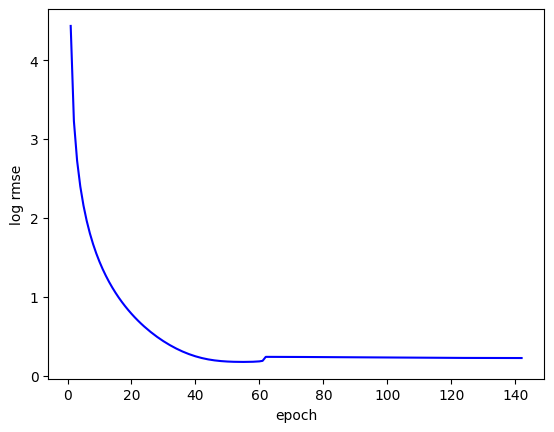

Loss in epoch 142 is 0.22710046246647836


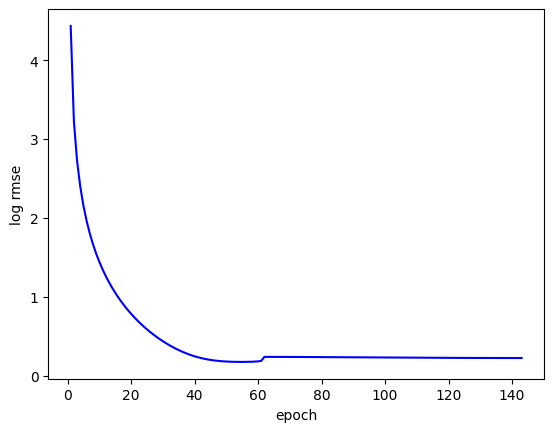

Loss in epoch 143 is 0.2270090952515602


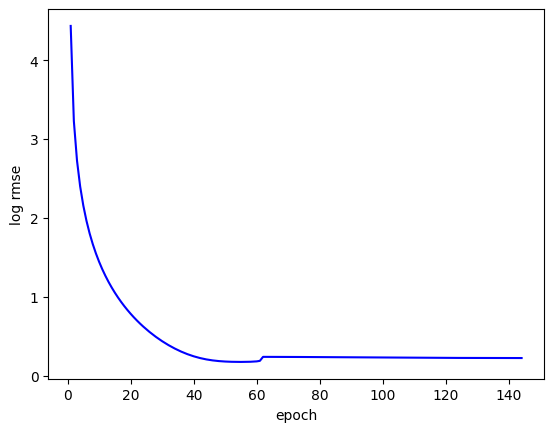

Loss in epoch 144 is 0.22695595398545265


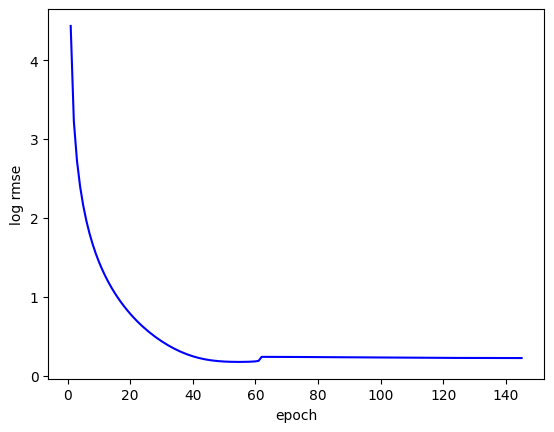

Loss in epoch 145 is 0.2268781453371048


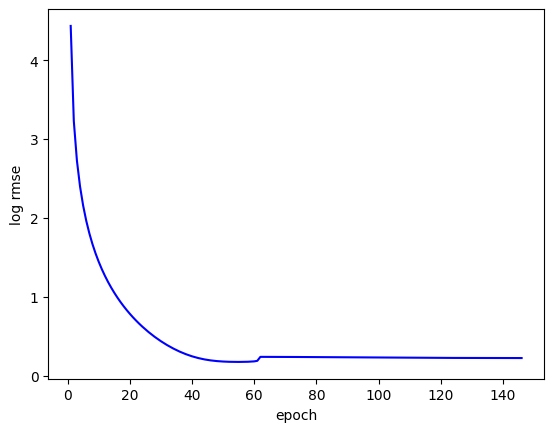

Loss in epoch 146 is 0.22681183591485024


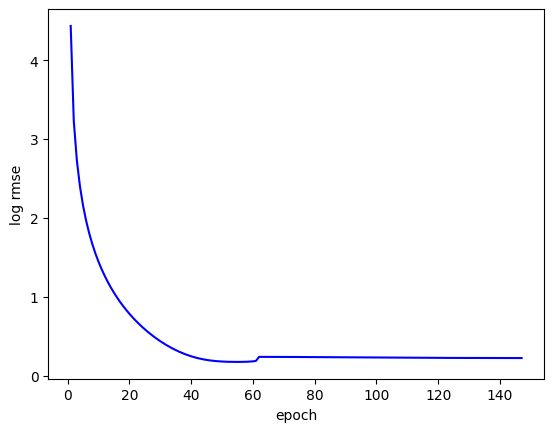

Loss in epoch 147 is 0.22676824033260345


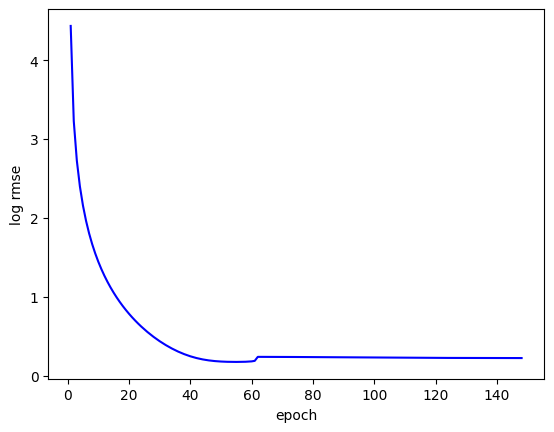

Loss in epoch 148 is 0.22669720128178597


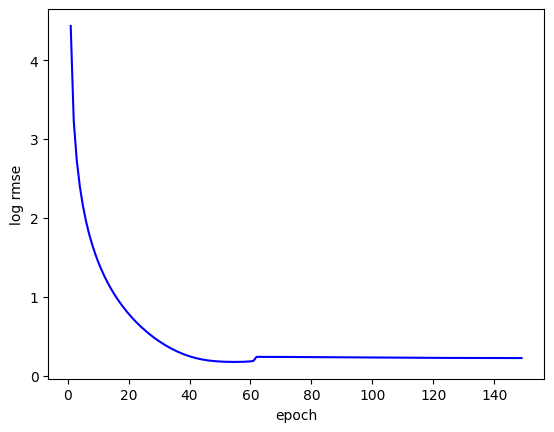

Loss in epoch 149 is 0.22666461542248725


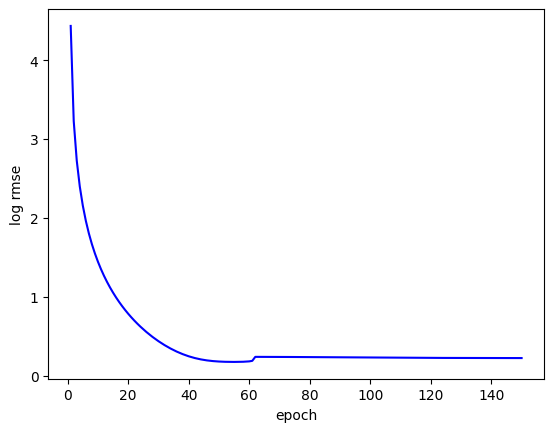

Loss in epoch 150 is 0.2266422688961029


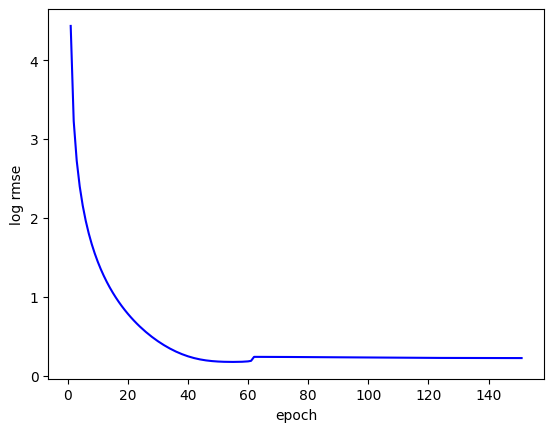

Loss in epoch 151 is 0.226578738540411


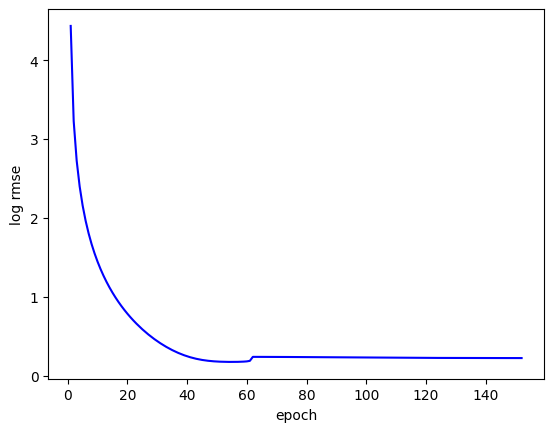

Loss in epoch 152 is 0.22655403316020967


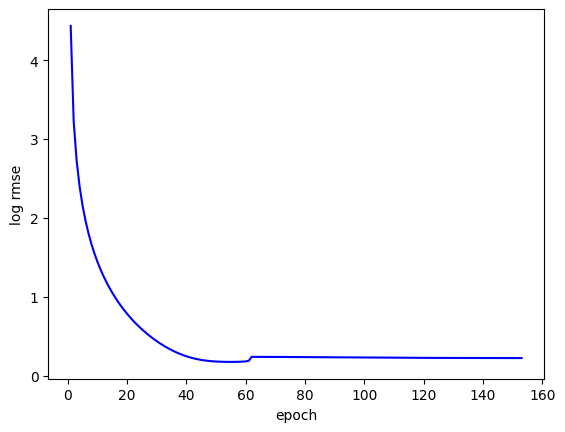

Loss in epoch 153 is 0.22645600363612176


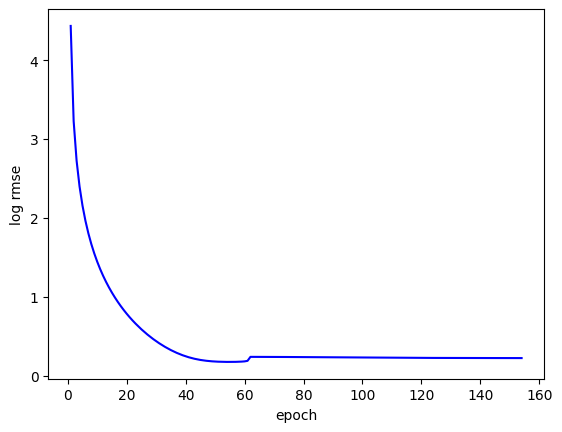

Loss in epoch 154 is 0.22639563977718352


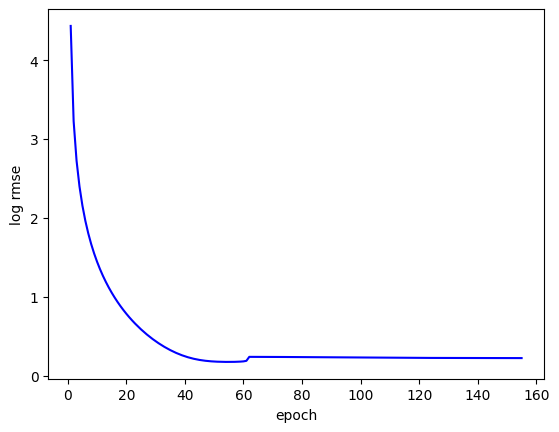

Loss in epoch 155 is 0.22631760835647582


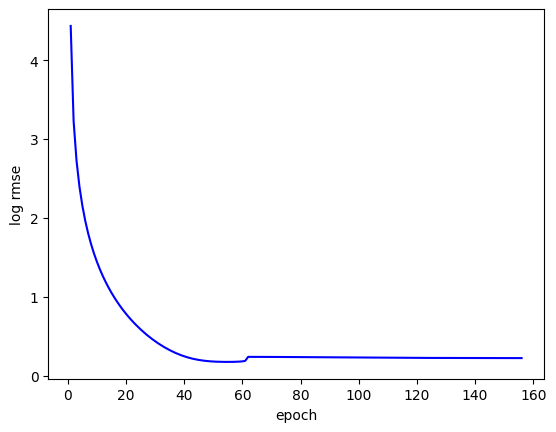

Loss in epoch 156 is 0.22625240311026573


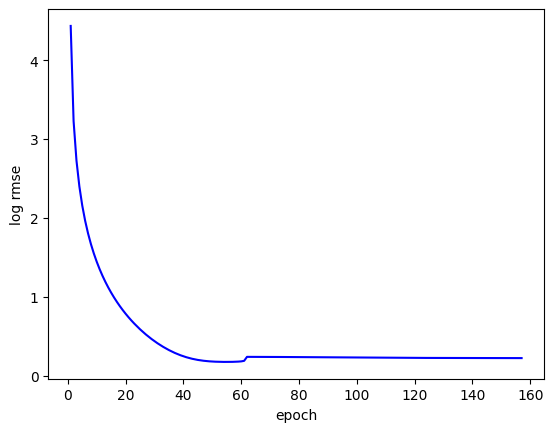

Loss in epoch 157 is 0.22619029134511948


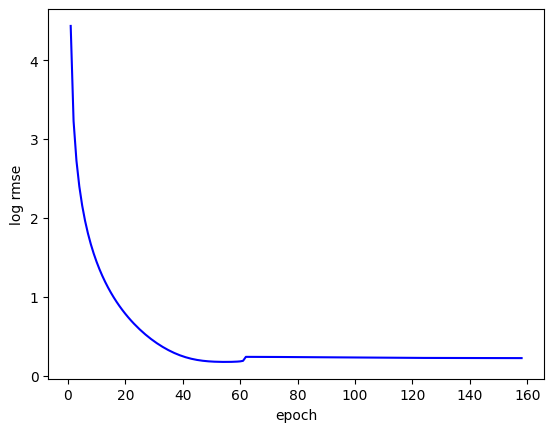

Loss in epoch 158 is 0.22614385634660722


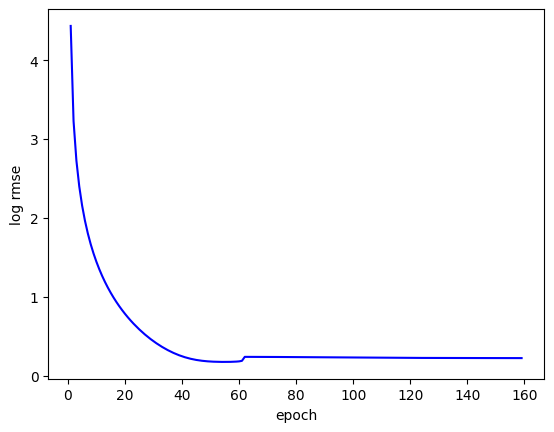

Loss in epoch 159 is 0.22616106942296027


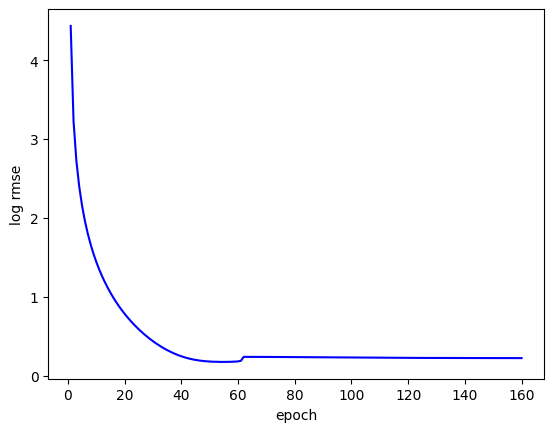

Loss in epoch 160 is 0.22611212879419326


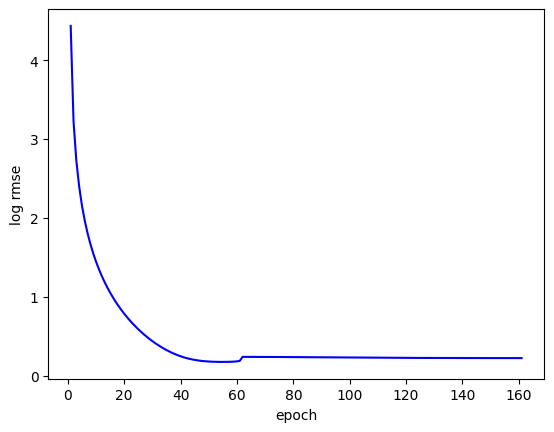

Loss in epoch 161 is 0.2261231668293476


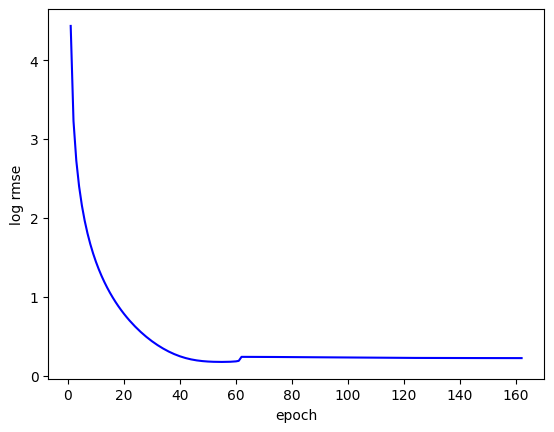

Loss in epoch 162 is 0.22610615864396094


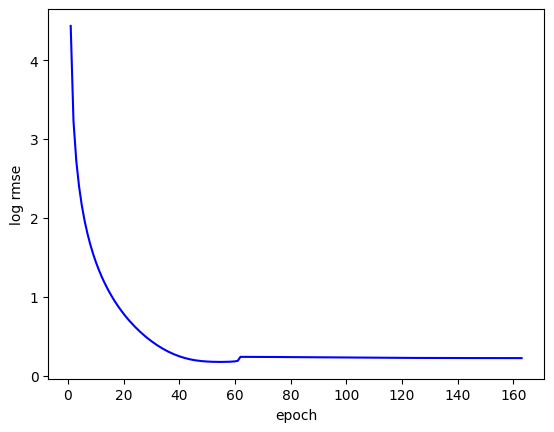

Loss in epoch 163 is 0.22608319148421288


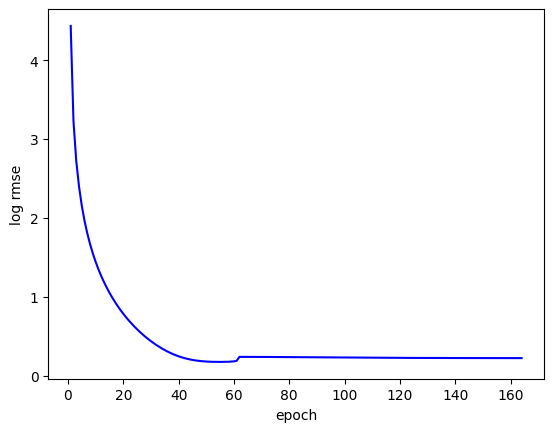

Loss in epoch 164 is 0.22606796622276307


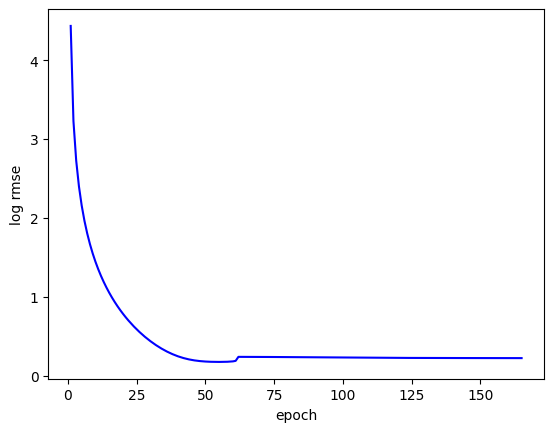

Loss in epoch 165 is 0.22598816230893135


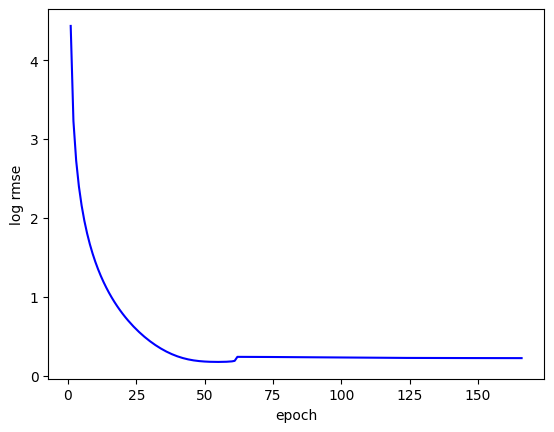

Loss in epoch 166 is 0.22592380419373512


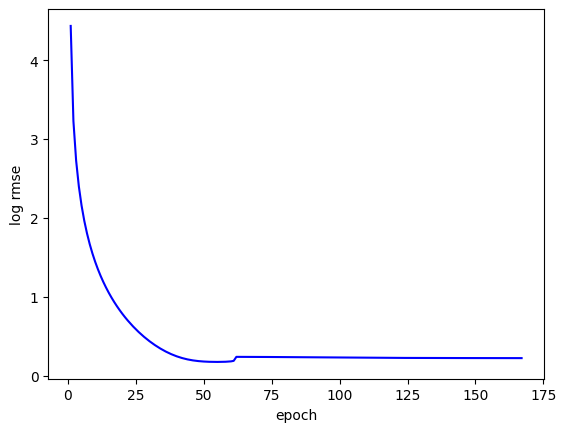

Loss in epoch 167 is 0.225946394354105


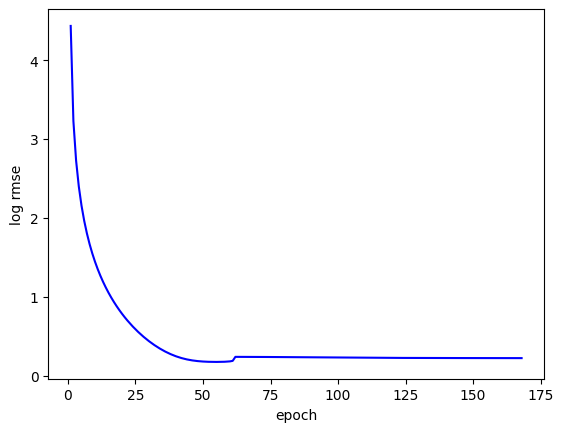

Loss in epoch 168 is 0.22593972384929656


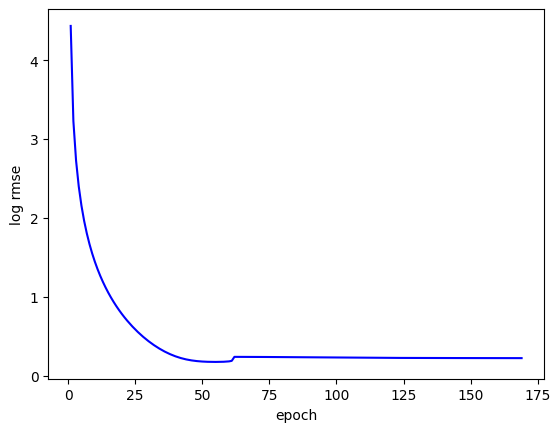

Loss in epoch 169 is 0.22582031711935996


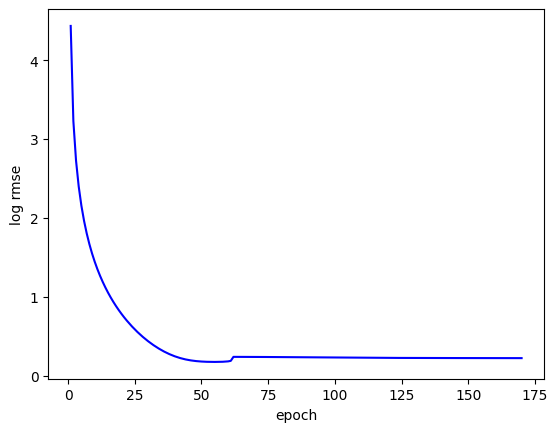

Loss in epoch 170 is 0.2258275866508484


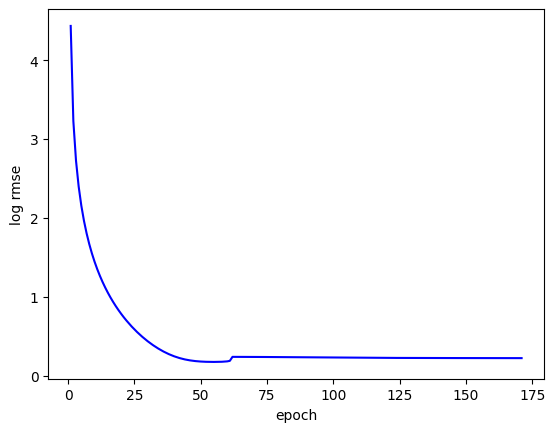

Loss in epoch 171 is 0.22580661997199059


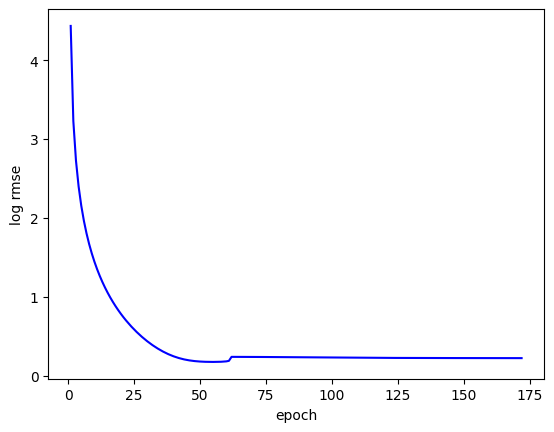

Loss in epoch 172 is 0.22580937296152115


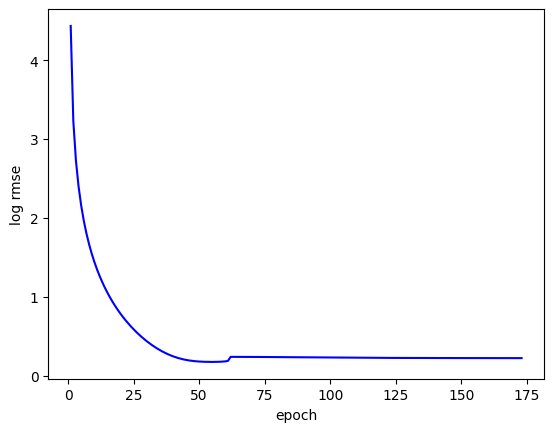

Loss in epoch 173 is 0.22577585503458977


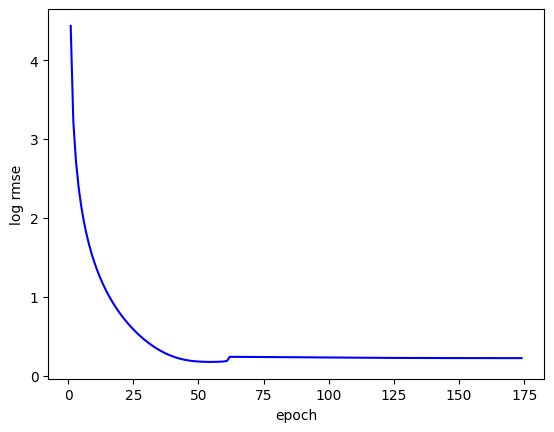

Loss in epoch 174 is 0.22575998827815055


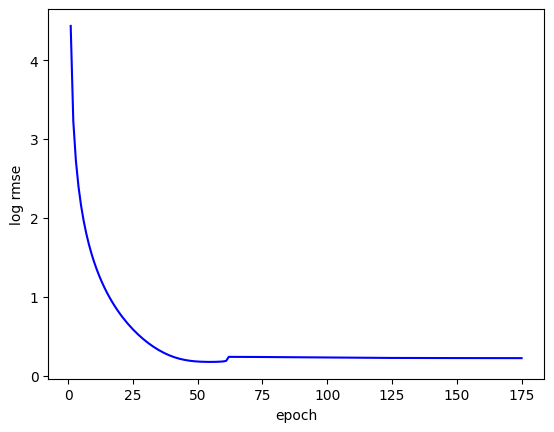

Loss in epoch 175 is 0.2257133550941944


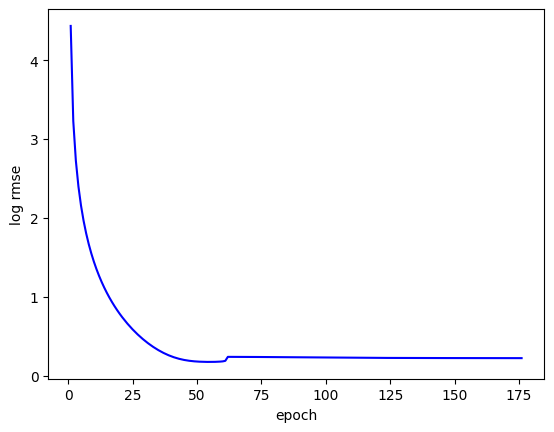

Loss in epoch 176 is 0.2257153384387493


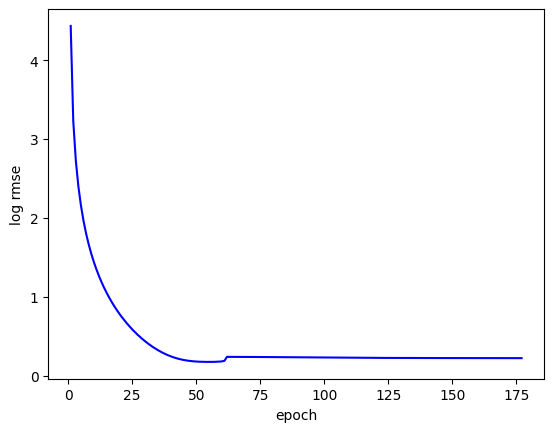

Loss in epoch 177 is 0.22565667256712912


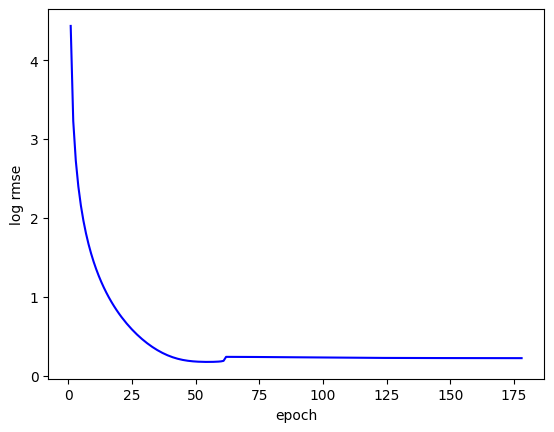

Loss in epoch 178 is 0.2256091721355915


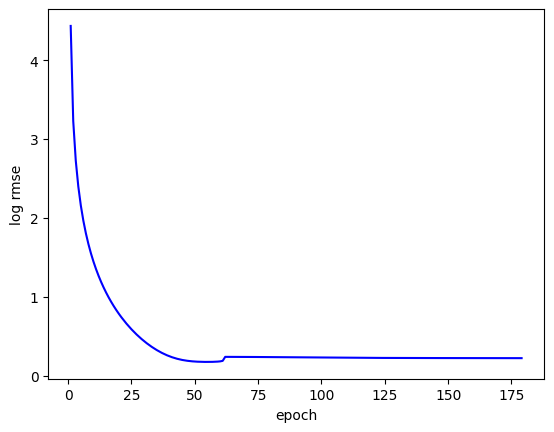

Loss in epoch 179 is 0.22553495466709136


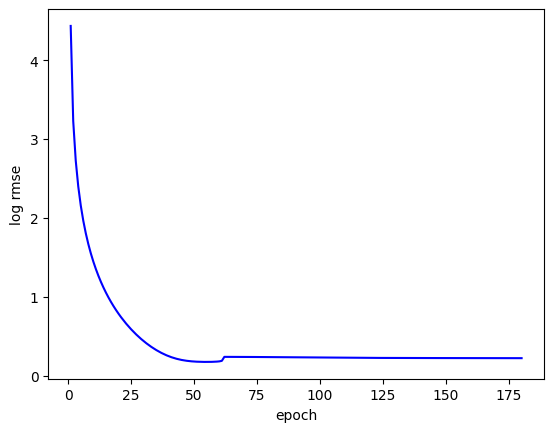

Loss in epoch 180 is 0.22538698017597197


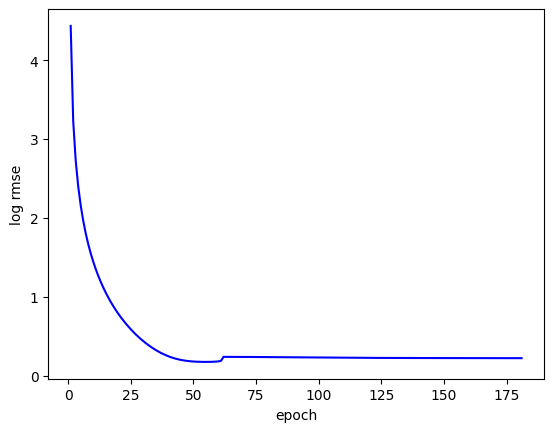

Loss in epoch 181 is 0.22534330636262895


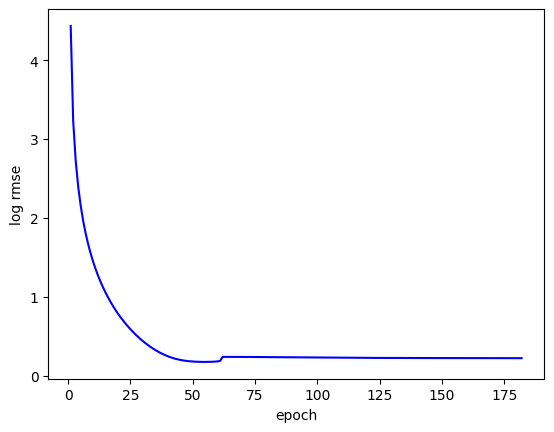

Loss in epoch 182 is 0.22533570677042009


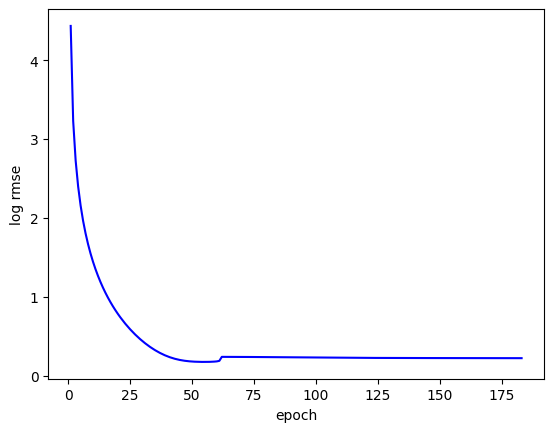

Loss in epoch 183 is 0.22534376084804536


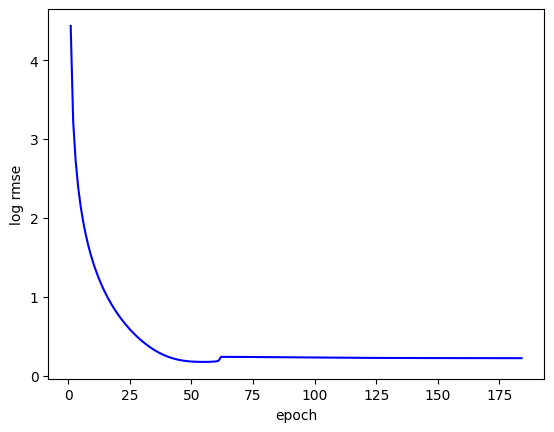

Loss in epoch 184 is 0.22528257146477698


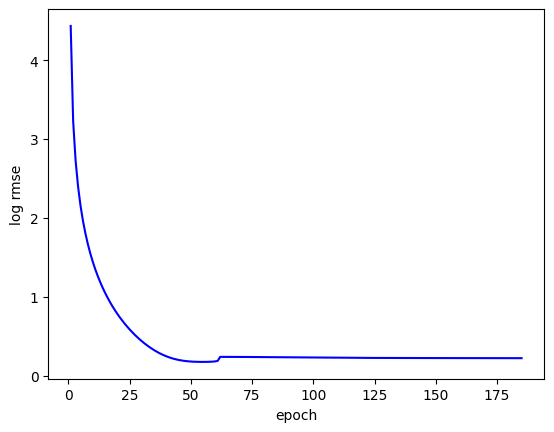

Loss in epoch 185 is 0.2252908580005169


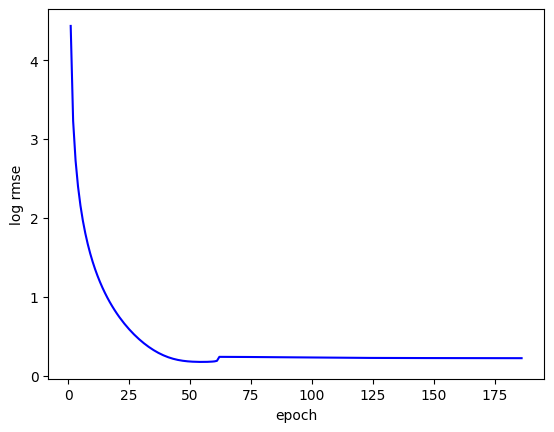

Loss in epoch 186 is 0.22524742409586906


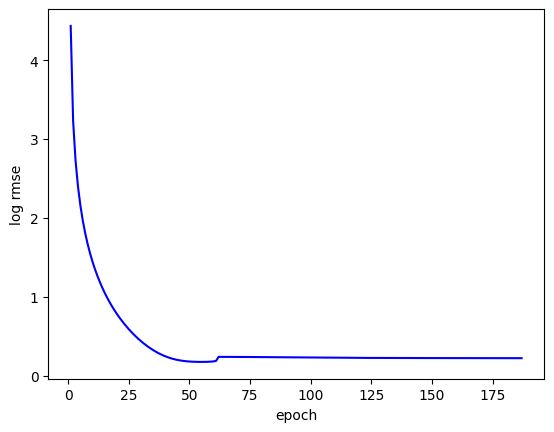

Loss in epoch 187 is 0.22514247000217438


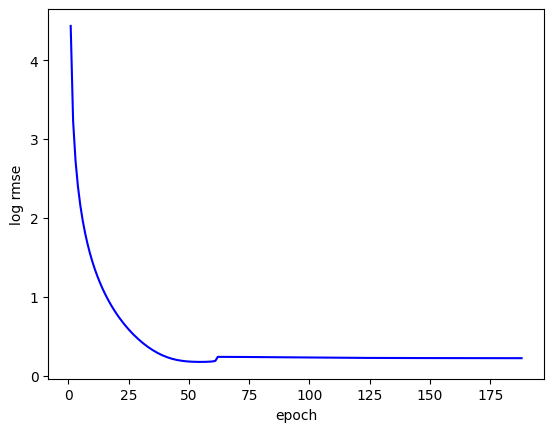

Loss in epoch 188 is 0.22515859231352806


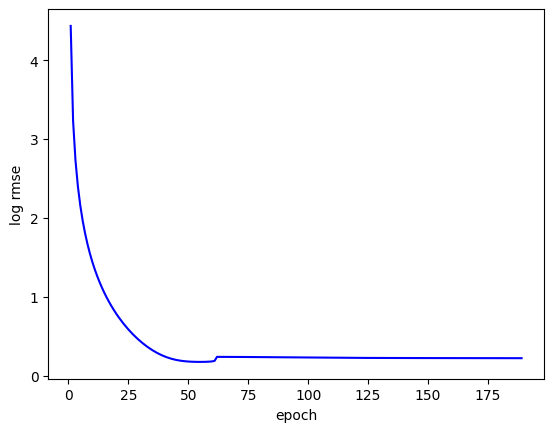

Loss in epoch 189 is 0.22515131831169127


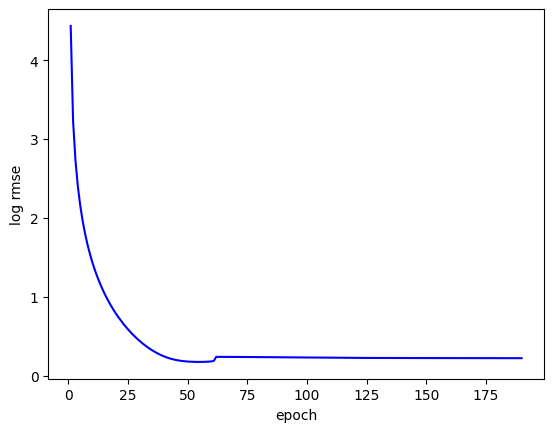

Loss in epoch 190 is 0.22517246529459953


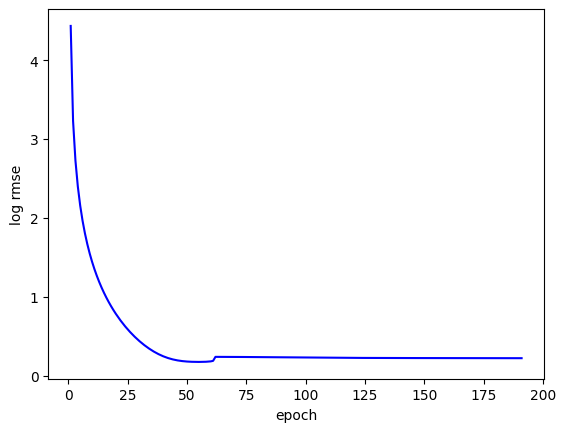

Loss in epoch 191 is 0.22511262595653533


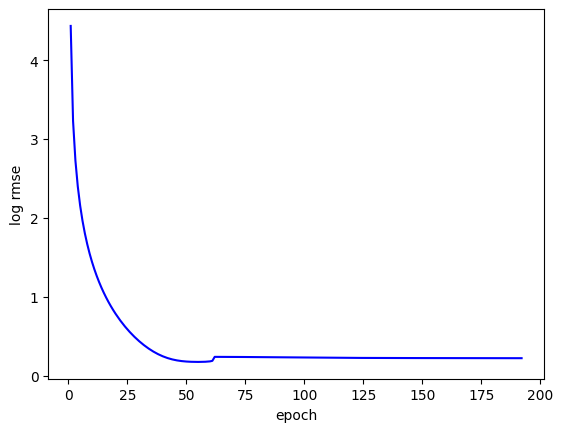

Loss in epoch 192 is 0.22509945631027223


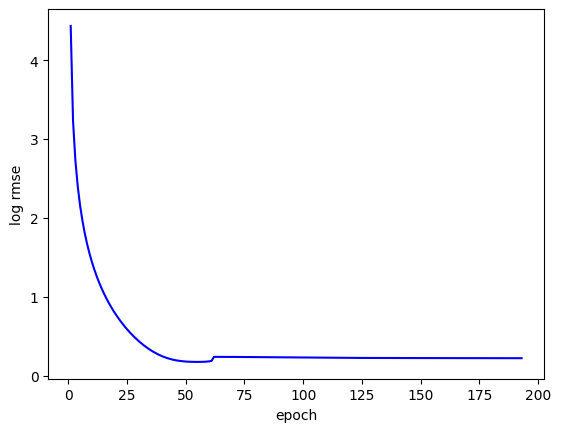

Loss in epoch 193 is 0.22513865530490876


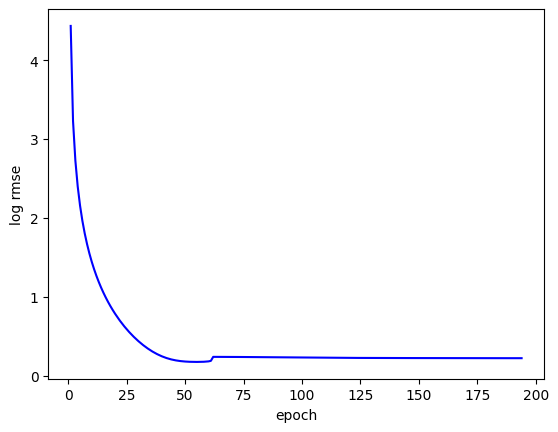

Loss in epoch 194 is 0.22513315677642823


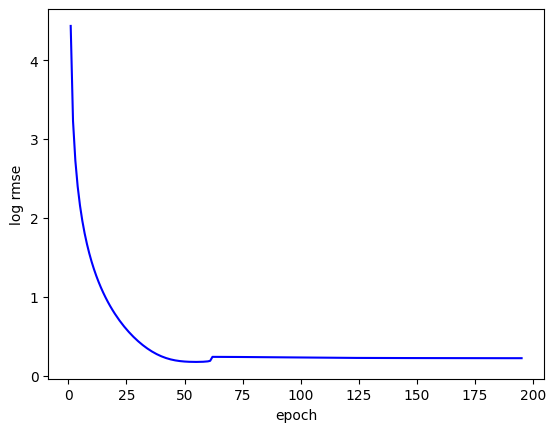

Loss in epoch 195 is 0.22512513548135757


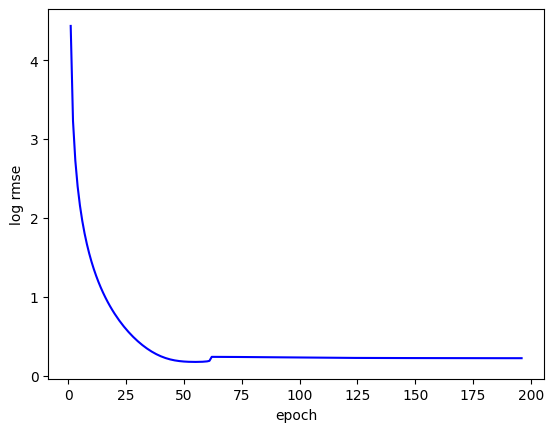

Loss in epoch 196 is 0.2250624977052212


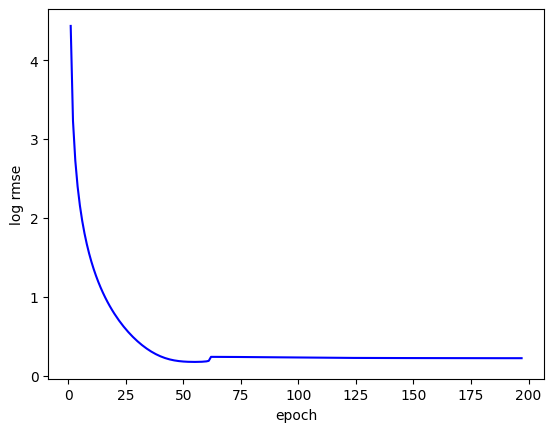

Loss in epoch 197 is 0.22508286088705062


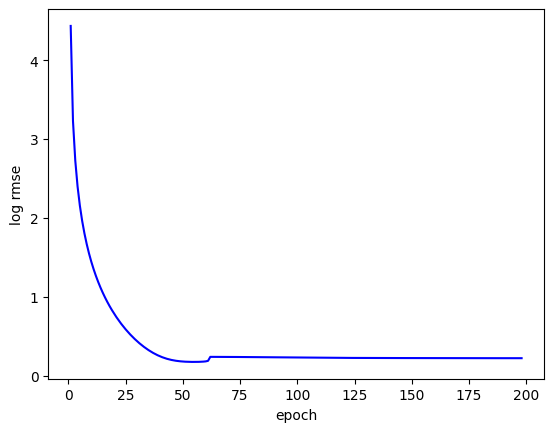

Loss in epoch 198 is 0.2250656358897686


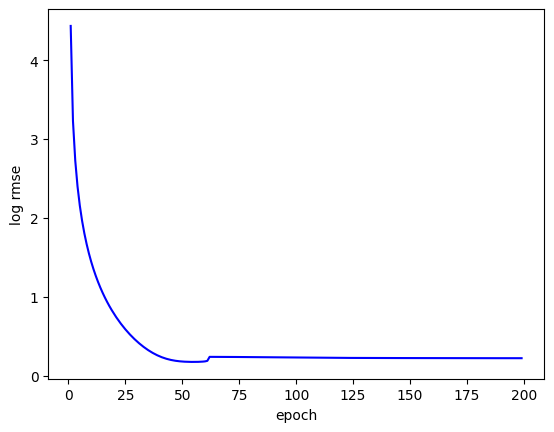

Loss in epoch 199 is 0.22499672174453736


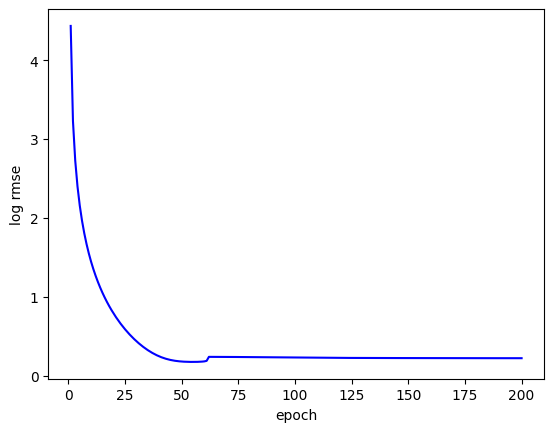

Loss in epoch 200 is 0.224953031539917


In [133]:
def main():
    train(
        net, train_features, train_labels, optimizer, loss, k, num_epochs
    )


if __name__ == "__main__":
    main()

## Debug ##